# <div style='padding:25px;background-color:maroon;color:white;border-radius:4px;font-size:100%;text-align: center'> Insurance Analytics and Prediction<br></div>

# <div style='padding:5px;background-color:maroon;color:white;border-radius:2px;font-size:100%;text-align: center'>Clustering Model Training<br></div>
### <span style="color:Khaki;">Problem Statement for Customer Segmentation (Clustering):
<span style="color: Chartreuse;">   &#9784; &nbsp;</span> Utilize clustering algorithms to group customers based on their banking behaviors, transaction histories, and demographics. <br>
- Apply clustering algorithms to group policyholders based on similar characteristics and behavior.
- Identify customer segments with common insurance needs and preferences.
- Tailor marketing strategies and product offerings to specific clusters, enhancing customer
engagement and increasing cross-selling opportunities.

![Clustering](cluster.png)

## <span style="color:Aqua;">Importing libraries from Python</span>

In [8]:
import pandas as pd
import os
pd.options.display.max_columns = None
pd.set_option("display.precision", 4)
pd.set_option('display.float_format', '{:.4f}'.format)

import numpy as np
import os

import seaborn as sns
sns.set_theme(context='notebook', style='white', palette='dark', font='sans-serif', font_scale=1, color_codes=True, rc=None)
sns.set_style({'axes.facecolor': 'white','axes.edgecolor': 'white'})

import matplotlib.pyplot as plt
plt.rcParams.update({
    'text.color': 'black',  # Change font color
    'axes.labelcolor': 'black',  # Change axis label color
    'xtick.color': 'black',  # Change x-tick color
    'ytick.color': 'black',  # Change y-tick color
    'font.weight': 'bold',  # Change font weight
    'axes.titleweight': 'bold',  # Change title weight
    'axes.labelweight': 'bold',# Change label weight
})


from sklearn.preprocessing import StandardScaler, RobustScaler,MinMaxScaler,LabelEncoder
from sklearn.model_selection import train_test_split

from sklearn.cluster import KMeans, DBSCAN
from kneed import KneeLocator
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

import pickle
from scipy.stats import ttest_ind
from termcolor import colored



## <span style="color:Aqua;">Reading model dataset:</span>

In [9]:
df = pd.read_feather('transfered_data.feather')
df.sample(3)

months_as_customer policy_bind_date policy_state  policy_deductable  \
256                 208       2000-06-18           IL                500   
396                 409       1995-07-29           IN               1000   
786                  85       1996-07-23           IL               2000   

    insured_sex insured_education_level insured_occupation insured_hobbies  \
256        MALE               Associate       craft-repair    base-jumping   
396        MALE             High School    protective-serv        exercise   
786        MALE                 College    priv-house-serv         dancing   

    insured_relationship incident_date             incident_type  \
256       other-relative    2015-02-22   Multi-vehicle Collision   
396            unmarried    2015-01-06  Single Vehicle Collision   
786            unmarried    2015-02-02   Multi-vehicle Collision   

     collision_type incident_severity authorities_contacted incident_state  \
256  Side Collision        Total Loss                 Other             SC   
396  Side Collision      Major Damage                 Other             NY   
786  Rear Collision      Minor Damage                  Fire             NY   

    incident_city incident_hour_of_the_day number_of_vehicles_involved  \
256     Arlington                       16                           3   
396     Riverwood                       19                           1   
786     Northbend                       14                           4   

    property_damage bodily_injuries witnesses police_report_available  \
256             YES               1         0                     YES   
396              NO               1         0                      NO   
786             YES               0         0                      NO   

    auto_make auto_year fraud_reported  age_boxcox  \
256    Accura      2004              N      4.1141   
396      Ford      2012              N      4.7266   
786    Toyota      2012              N      3.7413   

     policy_annual_premium_boxcox  total_claim_amount_boxcox  \
256                     1156.4819                103939.2246   
396                     1194.9467                155081.8992   
786                     1177.2152                122980.7358   

     injury_claim_cube  property_claim_cube  vehicle_claim_boxcox  
256             -24256                13352            81009.6226  
396             -31112                13248           130966.0312  
786              -9920                -9432           100136.5969

## <span style="color:Aqua;">Variable Partitioning:</span>

In [10]:
ordinal = ['insured_education_level','incident_severity',]

nominal = ['policy_state','insured_sex','insured_occupation','insured_hobbies','insured_relationship','incident_type',
           'collision_type','authorities_contacted','incident_state','incident_city','property_damage',
           'police_report_available','auto_make','fraud_reported']

discrete = ['months_as_customer','incident_hour_of_the_day','number_of_vehicles_involved','auto_year'
            ,'witnesses','bodily_injuries']
continuous = [
    'age_boxcox','policy_annual_premium_boxcox','total_claim_amount_boxcox','injury_claim_cube',
    'property_claim_cube','vehicle_claim_boxcox','insurance_age','vehicle_age','auto_year','policy_deductable']

date = ['policy_bind_date','incident_date']

non_cont =[]

len(ordinal + nominal + discrete +continuous + date)

34

In [11]:
df['insurance_age'] = pd.to_numeric((df.incident_date.dt.year - df.policy_bind_date.dt.year),errors='raise',downcast='integer')
df['vehicle_age'] = pd.to_numeric((df.incident_date.dt.year - df.auto_year.astype(int)),errors='raise',downcast='integer')

## <span style="color:Aqua;">Selecting Features:</span>

### <span style="color:Khaki;">Selecting features for modeling:

Selecting features basedon the characteristics. Removing few features may the quality of clustering.

In [12]:
fea1 = ['months_as_customer', 'policy_state', 'policy_deductable', 'insured_sex','insured_education_level',
    'insured_occupation', 'insured_hobbies', 'insured_relationship','incident_type','auto_make','auto_year',
    'age_boxcox', 'policy_annual_premium_boxcox', 'total_claim_amount_boxcox','insurance_age','vehicle_age',
    'fraud_reported'
]

fea2 = ['months_as_customer', 'policy_state', 'policy_deductable', 'insured_sex','insured_education_level',
    'insured_occupation', 'insured_hobbies', 'insured_relationship','incident_type','auto_make','auto_year',
    'age_boxcox', 'policy_annual_premium_boxcox', 'total_claim_amount_boxcox','insurance_age','vehicle_age',
    'fraud_reported','incident_severity', 'property_damage', 'bodily_injuries',  'property_claim_cube']

fea3 = ['months_as_customer', 'policy_state', 'policy_deductable', 'insured_sex','insured_education_level',
    'insured_occupation', 'insured_hobbies', 'insured_relationship','incident_type','auto_make','auto_year',
    'age_boxcox', 'policy_annual_premium_boxcox', 'total_claim_amount_boxcox','insurance_age','vehicle_age',
    'incident_severity', 'property_damage', 'bodily_injuries',  'property_claim_cube','incident_hour_of_the_day'
    ,'authorities_contacted','number_of_vehicles_involved','police_report_available','fraud_reported']

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 33 columns):
 #   Column                        Non-Null Count  Dtype         
---  ------                        --------------  -----         
 0   months_as_customer            1000 non-null   int16         
 1   policy_bind_date              1000 non-null   datetime64[ns]
 2   policy_state                  1000 non-null   category      
 3   policy_deductable             1000 non-null   int16         
 4   insured_sex                   1000 non-null   category      
 5   insured_education_level       1000 non-null   category      
 6   insured_occupation            1000 non-null   category      
 7   insured_hobbies               1000 non-null   category      
 8   insured_relationship          1000 non-null   category      
 9   incident_date                 1000 non-null   datetime64[ns]
 10  incident_type                 1000 non-null   category      
 11  collision_type                1

## <span style="color:Aqua;"> Encoding Categorical Features:</span> 

In [14]:
insured_sex_map = { 'FEMALE': 0,'MALE':1  }
property_damage_map = { 'NO':0, 'YES':1 }
police_report_available_map = { 'NO':0, 'YES':1 }
fraud_reported_map = { 'N':0, 'Y':1 }

In [15]:
df['insured_sex'] = pd.to_numeric(df['insured_sex'].map(insured_sex_map),errors='raise',downcast='integer')
df['property_damage'] = pd.to_numeric(df['property_damage'].map(property_damage_map),errors='raise',downcast='integer')
df['police_report_available'] = pd.to_numeric(df['police_report_available'].map(police_report_available_map),errors='raise',downcast='integer')
df['fraud_reported'] = pd.to_numeric(df['fraud_reported'].map(fraud_reported_map),errors='raise',downcast='integer')

In [16]:
policy_state = pd.get_dummies(df['policy_state'],prefix = 'policy_state_', dtype='int8')
insured_occupation = pd.get_dummies(df['insured_occupation'],prefix = 'insured_occ_',dtype='int8')
insured_hobbies = pd.get_dummies(df['insured_hobbies'],prefix = 'insured_hobbies_',dtype='int8')
insured_relationship = pd.get_dummies(df['insured_relationship'],prefix = 'insured_rela_',dtype='int8')
incident_type = pd.get_dummies(df['incident_type'],prefix = 'incident_type_',dtype='int8')
collision_type = pd.get_dummies(df['collision_type'],prefix = 'collision_type_',dtype='int8')
authorities_contacted = pd.get_dummies(df['authorities_contacted'],prefix = 'authorities_contacted_',dtype='int8')
incident_state = pd.get_dummies(df['incident_state'],prefix = 'incident_state_',dtype='int8')
incident_city = pd.get_dummies(df['incident_city'],prefix = 'incident_city_',dtype='int8')
auto_make = pd.get_dummies(df['auto_make'],prefix = 'auto_make_',dtype='int8')

en = LabelEncoder()
df['insured_education_level'] = en.fit_transform(df['insured_education_level']).astype('int8')

os.makedirs('pkls', exist_ok=True)
with open(r'pkls/edu_en.pkl','wb') as f:
    pickle.dump(en, f)
    
en1 = LabelEncoder()
df['incident_severity'] = en.fit_transform(df['incident_severity']).astype('int8')

os.makedirs('pkls', exist_ok=True)
with open(r'pkls/inc_seve_en.pkl','wb') as f:
    pickle.dump(en, f)

df1= pd.concat([df,policy_state,insured_hobbies,insured_occupation,insured_relationship,incident_type,collision_type,
                authorities_contacted,incident_state,incident_city,auto_make],axis=1)
df1 = df1.drop(['policy_state','insured_hobbies','insured_occupation','insured_relationship','incident_type','collision_type',
                'authorities_contacted','incident_state','incident_city','auto_make'],axis=1)

In [17]:
policy_state_ohe = [col for col in df1.columns if 'policy_state_' in col]
insured_occupation_ohe = [col for col in df1.columns if 'insured_occ_' in col]
insured_hobbies_ohe = [col for col in df1.columns if 'insured_hobbies_' in col]
insured_relationship_ohe = [col for col in df1.columns if 'insured_rela_' in col]
incident_type_ohe = [col for col in df1.columns if 'incident_type_' in col]
collision_type_ohe = [col for col in df1.columns if 'collision_type_' in col]
authorities_contacted_ohe = [col for col in df1.columns if 'authorities_contacted_' in col]
incident_state_ohe = [col for col in df1.columns if 'incident_state_' in col]
incident_city_ohe = [col for col in df1.columns if 'incident_city_' in col]
auto_make_ohe = [col for col in df1.columns if 'auto_make_' in col]

In [18]:
fea1 = ['months_as_customer',  'policy_deductable', 'insured_sex','auto_year','insured_education_level',
    'age_boxcox', ]

fea1.extend(collision_type_ohe + insured_hobbies_ohe + insured_relationship_ohe + incident_type_ohe)

fea2 = ['months_as_customer', 'policy_deductable', 'insured_sex','insured_education_level','auto_year',
    'age_boxcox', 'policy_annual_premium_boxcox', 'total_claim_amount_boxcox','insurance_age','vehicle_age',
    'fraud_reported','incident_severity', 'property_damage', 'bodily_injuries',  'property_claim_cube']

fea2.extend(policy_state_ohe  + insured_hobbies_ohe + insured_relationship_ohe + incident_type_ohe +
                   auto_make_ohe + incident_city_ohe)

fea3 = ['months_as_customer', 'policy_deductable', 'insured_sex','insured_education_level','auto_year',
    'age_boxcox', 'policy_annual_premium_boxcox', 'total_claim_amount_boxcox','insurance_age','vehicle_age',
    'incident_severity', 'property_damage', 'bodily_injuries',  'property_claim_cube','incident_hour_of_the_day'
    ,'number_of_vehicles_involved','police_report_available','fraud_reported']

fea3.extend(policy_state_ohe + insured_occupation_ohe + insured_hobbies_ohe + insured_relationship_ohe + incident_type_ohe +
                   auto_make_ohe + authorities_contacted_ohe + incident_city_ohe)

In [19]:
feature_sets = {
    'fea1': fea1,
    'fea2': fea2,
    'fea3': fea3
}

# <span style="color:Tomato;">Training the model without scaling the dataset:</span>

#### <span style="color:Aqua;">I am going to use KMeans clustering for our problem. Hiearchical Clustering may not useful since we have more data point and variety of data.</span>

## <span style="color:Aqua;">Evaluation Metrics Interpretation:</span>

<span style="color:Khaki;"> Interpretation of silhouette scores:

- 1 to 0: Poor clustering, with many points assigned to the wrong clusters.
- 0 to 0.25: Weak structure, which might indicate overlapping clusters.
- 0.25 to 0.50: Reasonable clustering.
- 0.50 to 0.75: Good clustering.
- 0.75 to 1: Strong clustering, indicating well-defined clusters.

<span style="color:Khaki;"> Interpretation of Calinski-Harabasz Index: </span>

- Higher is better.
- Measures the ratio of the sum of between-cluster dispersion and within-cluster dispersion.

<span style="color:Khaki;"> Interpretation of Davies-Bouldin Index: </span>

- Range: 0 to ∞
-  Lower values indicate better clustering.
- Measures the average similarity ratio of each cluster with its most similar cluster.

## <span style="color:Aqua;">Training the model with all relevant Features:</span>

### <span style="color:Khaki;">Finding K value using Elbow method:

In [20]:
wcss = {}
for name, features in feature_sets.items():
    wcss[name] = []
    for k in range(1,6):
        kmeans = KMeans(n_clusters=k,init='k-means++',random_state=42)
        kmeans.fit(df1[features])
        wcss[name].append(kmeans.inertia_)

print(wcss)

{'fea1': [387285252.2760714, 56566449.83699363, 13250465.525145825, 10443846.690929832, 7225111.220421547], 'fea2': [3616502169433.4014, 1299505570510.4424, 716411114560.7101, 549577066605.8137, 445596067140.97424], 'fea3': [3616502220644.5645, 1299505619340.4348, 716411163104.6392, 549577114657.5503, 445596115057.35156]}


#### <span style="color:Khaki;">Plotting Within-Cluster Sum of Squares (WCSS) values to find the Elbow:

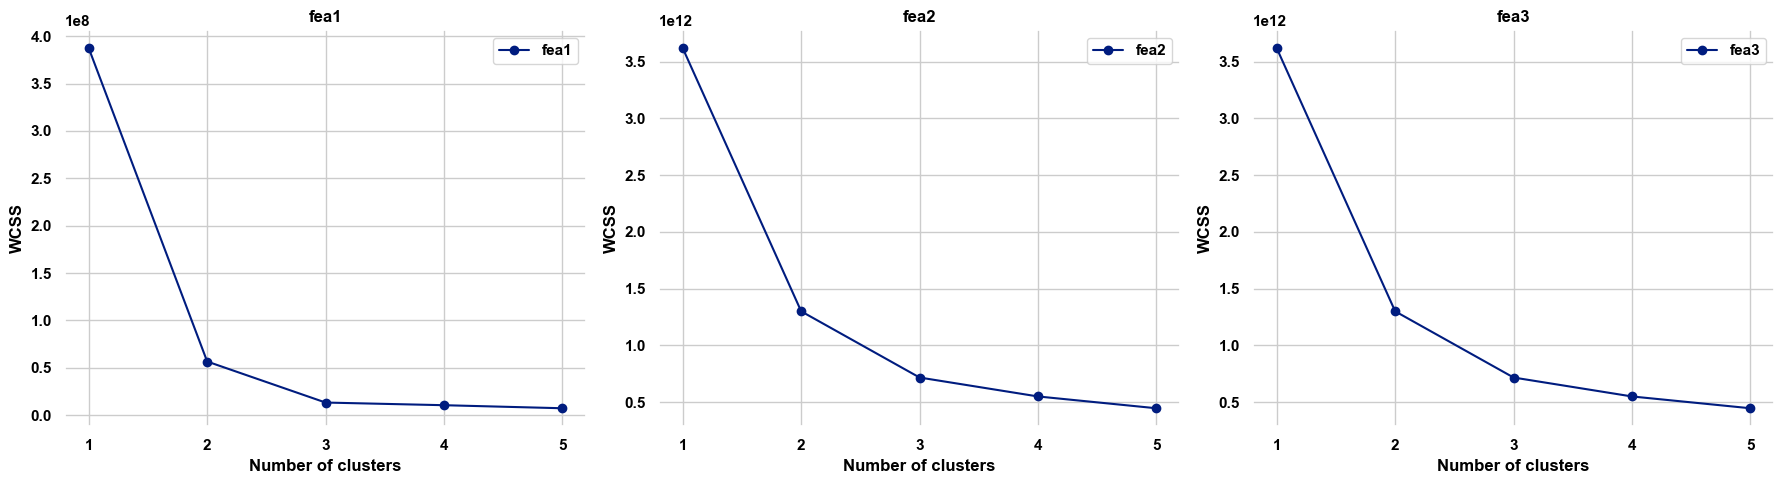

In [21]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
clusters = range(1, 6)

for ax, (name, inertia) in zip(axes, wcss.items()):
    ax.plot(clusters, inertia, marker='o', linestyle='-', label=name)
    ax.set_title(name)
    ax.set_xticks(clusters)
    ax.set_xlabel('Number of clusters')
    ax.set_ylabel('WCSS')
    ax.legend()
    ax.grid(True)

plt.tight_layout()
plt.show()

<span style="color:DodgerBlue;">From the above plot we can see that the Knee is located near the value 2

#### <span style="color:Khaki;">Finding knee locator in the Elbow curve using KneeLocator class:

In [22]:
optimal_k_wcss = {}

for name, inertia in wcss.items():
    kl = KneeLocator(range(1, 6), inertia, curve='convex', direction='decreasing')
    optimal_k_wcss[name] = kl.elbow

print(optimal_k_wcss)

{'fea1': np.int64(2), 'fea2': np.int64(2), 'fea3': np.int64(2)}


<span style="color:DodgerBlue;">Knee Locator also confirms that the Knee is located near the value 2

### <span style="color:Khaki;">Finding K value using silhouette score method:

In [23]:
silhouette_coefficients = {}
for name, features in feature_sets.items():
    silhouette_coefficients[name] = []
    for k in range(2,6):
        kmeans = KMeans(n_clusters=k,init='k-means++',random_state=42)
        kmeans.fit(df1[features])
        score = silhouette_score(df1[features],kmeans.labels_)
        silhouette_coefficients[name].append(score)

print(silhouette_coefficients)

{'fea1': [np.float64(0.7796925999271973), np.float64(0.7883181408803311), np.float64(0.6950332325119808), np.float64(0.633725258993461)], 'fea2': [np.float64(0.5974657217337447), np.float64(0.4702658814518599), np.float64(0.3949255755466923), np.float64(0.4086051507167083)], 'fea3': [np.float64(0.597465707214931), np.float64(0.4702658527392022), np.float64(0.3949255355087701), np.float64(0.40860510000213895)]}


<span style="color:DodgerBlue;">THe highest silouette scode we obtaine is around 77 from fea1.

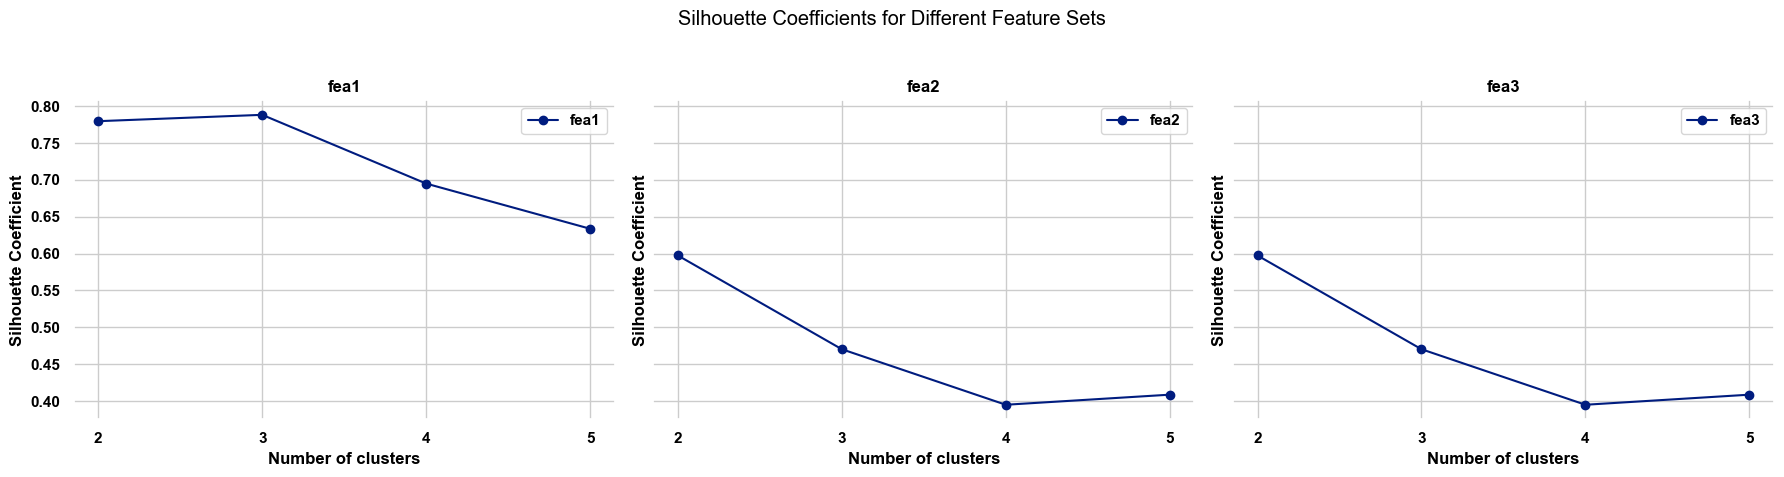

In [24]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharey=True)

for ax, (name, scores) in zip(axes, silhouette_coefficients.items()):
    ax.plot(range(2, 6), scores, marker='o', linestyle='-', label=name)
    ax.set_title(name)
    ax.set_xticks(range(2, 6))
    ax.set_xlabel('Number of clusters')
    ax.set_ylabel('Silhouette Coefficient')
    ax.legend()
    ax.grid(True)

plt.suptitle('Silhouette Coefficients for Different Feature Sets')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

<span style="color:DodgerBlue;">We can see the highest Silhouette score is near the vale2  The Silhouette score also confirms that the Knee is located near the value 2. 

In [25]:
optimal_k_silhouette = {}

for name, scores in silhouette_coefficients.items():
    optimal_k = range(2, 6)[scores.index(max(scores))]
    optimal_k_silhouette[name] = optimal_k
    
for name, optimal_k in optimal_k_silhouette.items():
    print(f"Optimal number of clusters for {name} (Silhouette): {optimal_k}")

Optimal number of clusters for fea1 (Silhouette): 3
Optimal number of clusters for fea2 (Silhouette): 2
Optimal number of clusters for fea3 (Silhouette): 2


<span style="color:DodgerBlue;"> Considering silhouette_coefficients, fea1 is performing better however, WCSS suggest 2 clusters whereas silhouette_coefficients suggest 3 clusters. So i gonna plot cluster scatter to decide which is the optimal clusters for our problem.

#### <span style="color:Khaki;"> Differnciating 2 cluters using PCA and visualizing via Scatter plot:

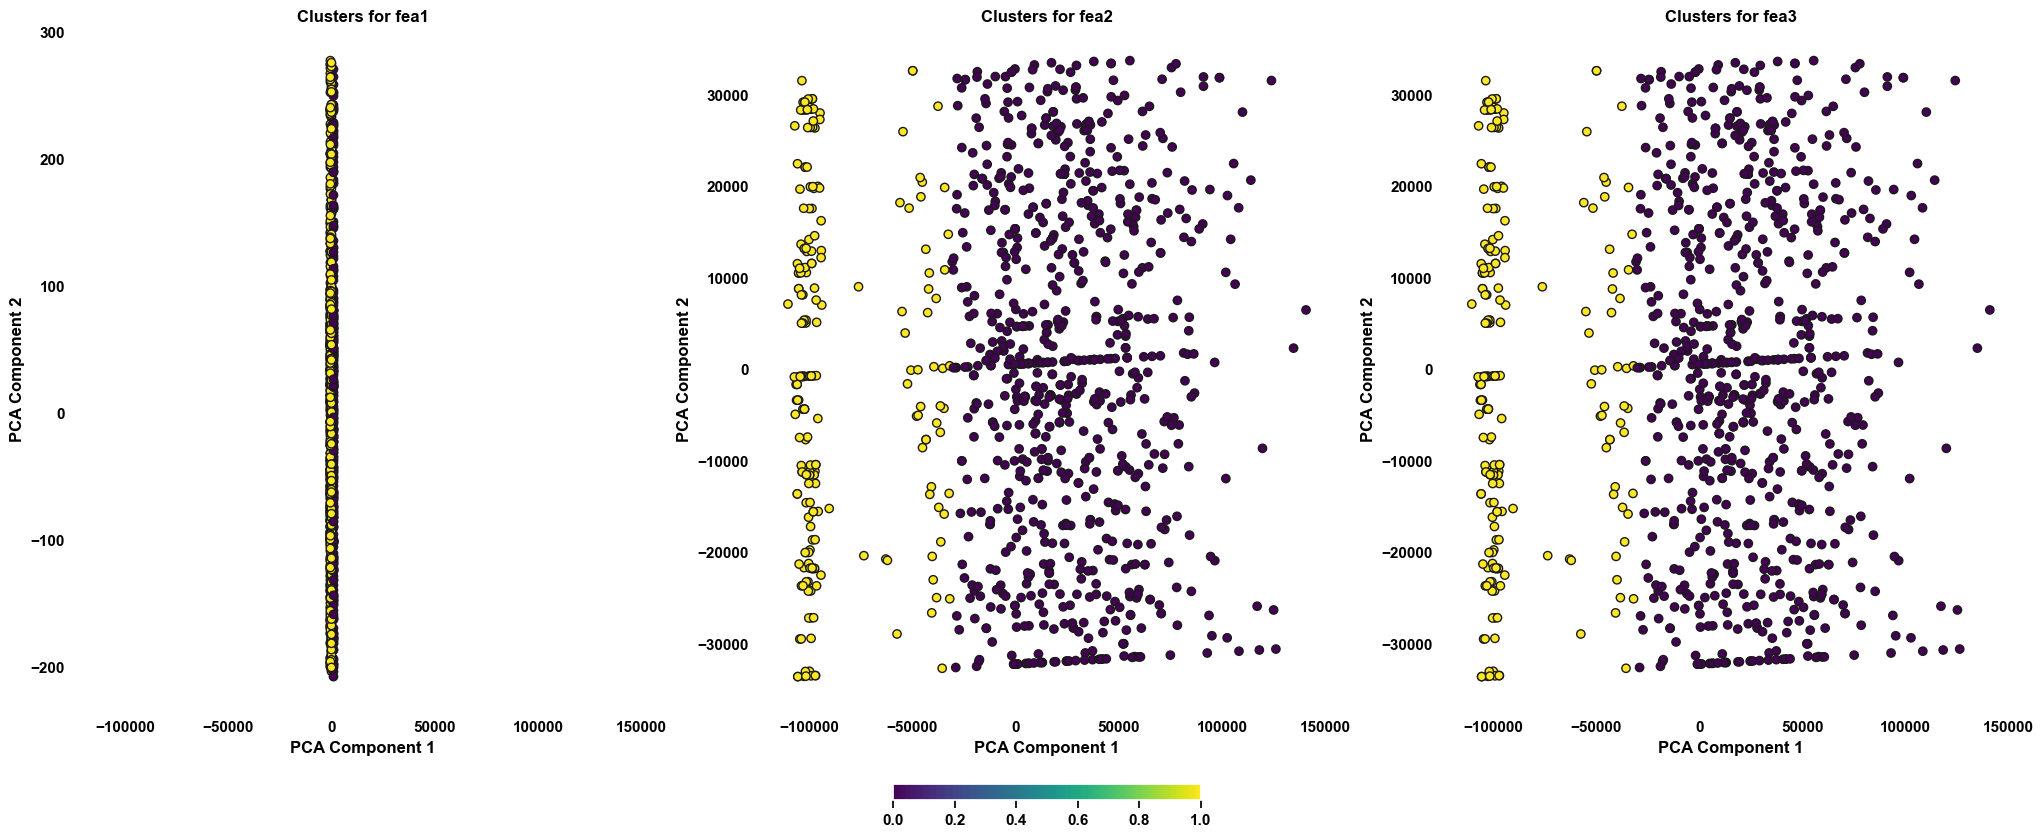

In [26]:
fig, axes = plt.subplots(1, 3, figsize=(25, 10), sharex=True)

for ax, (name, features) in zip(axes, feature_sets.items()):
    pca = PCA(n_components=2)
    x_pca = pca.fit_transform(df1[features])
    
    kmeans = KMeans(n_clusters=2, init='k-means++', random_state=42)
    labels = kmeans.fit_predict(df1[features])
    
    scatter = ax.scatter(x_pca[:, 0], x_pca[:, 1], c=labels, cmap='viridis', marker='o', edgecolor='k')
    ax.set_title(f'Clusters for {name}')
    ax.set_xlabel('PCA Component 1')
    ax.set_ylabel('PCA Component 2')
    
plt.colorbar(scatter, ax=axes, orientation='horizontal', fraction=0.02, pad=0.1)
plt.show()


#### <span style="color:Khaki;"> Differnciating 3 cluters using PCA and visualizing 3d Scatter plot:

/tmp/ipykernel_9447/3901522565.py:32: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


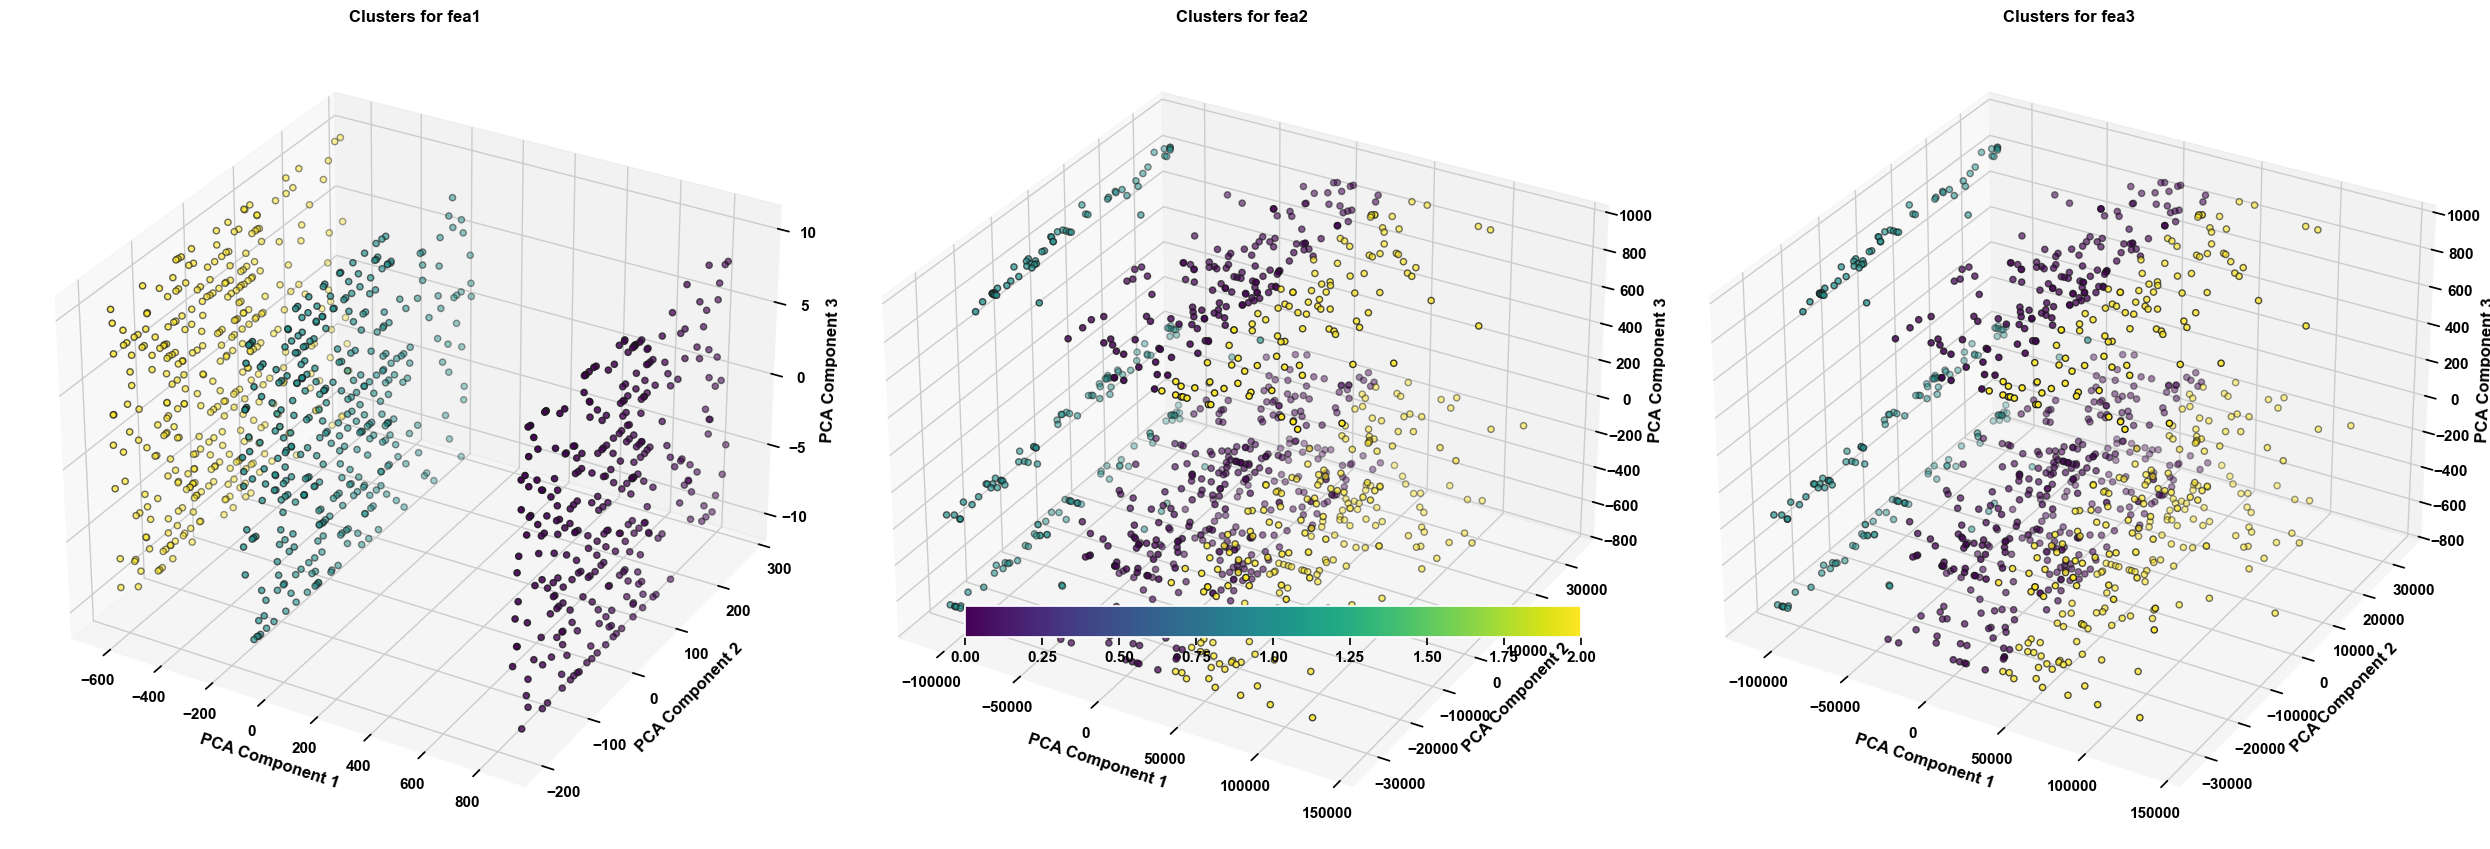

In [27]:
from mpl_toolkits.mplot3d import Axes3D  # Import the 3D plotting toolkit

# Create subplots for 3D plotting
fig = plt.figure(figsize=(25, 20))

# Loop over the feature sets and create a 3D scatter plot for each
for i, (name, features) in enumerate(feature_sets.items()):
    # Add a 3D subplot
    ax = fig.add_subplot(1, 3, i + 1, projection='3d')
    
    # Perform PCA
    pca = PCA(n_components=3)
    x_pca = pca.fit_transform(df1[features])
    
    # Run KMeans
    kmeans = KMeans(n_clusters=3, init='k-means++', random_state=42)
    labels = kmeans.fit_predict(df1[features])
    
    # Create a 3D scatter plot
    scatter = ax.scatter(x_pca[:, 0], x_pca[:, 1], x_pca[:, 2], c=labels, cmap='viridis', marker='o', edgecolor='k')
    
    # Set title and axis labels
    ax.set_title(f'Clusters for {name}')
    ax.set_xlabel('PCA Component 1')
    ax.set_ylabel('PCA Component 2')
    ax.set_zlabel('PCA Component 3')

# Add color bar
fig.colorbar(scatter, ax=[fig.axes[i] for i in range(3)], orientation='horizontal', fraction=0.02, pad=0.1)

# Show the plot
plt.tight_layout()
plt.show()

#### <span style="color:Khaki;"> This suggests that the simpler model with fewer features (fea1) is more effective at creating distinct, well-separated clusters. The additional features in fea2 and fea3 may be introducing noise or redundant information that doesn't improve the clustering performance. In the 2-cluster plot, the clusters may seem a bit less refined compared to the 3-cluster version, especially in the 3D plots where the 3-cluster setup has distinct regions.</span>
#### <span style="color:green;"> The 3-cluster solution seems more appropriate based on both the silhouette score and visual separation in the plots.</span>

# <span style="color:Tomato;">Training the model after scaling the dataset:</span>


#### <span style="color:Khaki;"> Scaling the data:

In [28]:
continuous_features = ['months_as_customer', 'policy_deductable', 'auto_year', 'age_boxcox', ]

categorical_features = collision_type_ohe + collision_type_ohe + incident_type_ohe + insured_relationship_ohe + insured_hobbies_ohe
categorical_features

['collision_type__Front Collision',
 'collision_type__Others',
 'collision_type__Rear Collision',
 'collision_type__Side Collision',
 'collision_type__Front Collision',
 'collision_type__Others',
 'collision_type__Rear Collision',
 'collision_type__Side Collision',
 'incident_type__Multi-vehicle Collision',
 'incident_type__Parked Car',
 'incident_type__Single Vehicle Collision',
 'incident_type__Vehicle Theft',
 'insured_rela__husband',
 'insured_rela__not-in-family',
 'insured_rela__other-relative',
 'insured_rela__own-child',
 'insured_rela__unmarried',
 'insured_rela__wife',
 'insured_hobbies__base-jumping',
 'insured_hobbies__basketball',
 'insured_hobbies__board-games',
 'insured_hobbies__bungie-jumping',
 'insured_hobbies__camping',
 'insured_hobbies__chess',
 'insured_hobbies__cross-fit',
 'insured_hobbies__dancing',
 'insured_hobbies__exercise',
 'insured_hobbies__golf',
 'insured_hobbies__hiking',
 'insured_hobbies__kayaking',
 'insured_hobbies__movies',
 'insured_hobbies__pa

In [29]:
df1[fea1].shape

(1000, 40)

In [30]:
scales = {'std_scale' : StandardScaler(),
'mm_scale' : MinMaxScaler(feature_range=(0,1)),
'rob_scale' : RobustScaler()
}
scaled_dfs = {}
for scaler_name, scaler in scales.items():
    scaled_continuous = scaler.fit_transform(df1[continuous_features])
    scaled_df = np.hstack((scaled_continuous, df1[categorical_features]))

    scaled_dfs[scaler_name] = scaled_df
    print(scaler_name, '---', scaled_df.shape)

std_scale --- (1000, 42)
mm_scale --- (1000, 42)
rob_scale --- (1000, 42)


#### <span style="color:Khaki;"> Training the model:

In [31]:
silhouette_avg = {}
calinski_harabasz = {}
davies_bouldin = {}
labels = {}

for scaler_name, scaled_df in scaled_dfs.items():
    kmeans = KMeans(n_clusters=3, random_state=42)
    kmeans.fit(scaled_df)
    labels[scaler_name] = kmeans.labels_

    silhouette_avg[scaler_name] = silhouette_score(scaled_df, kmeans.labels_)
    calinski_harabasz[scaler_name] = calinski_harabasz_score(scaled_df, kmeans.labels_)
    davies_bouldin[scaler_name] = davies_bouldin_score(scaled_df, kmeans.labels_)

In [32]:
print(f"silhouette_avg -- {silhouette_avg}")
print(f"calinski_harabasz -- {calinski_harabasz}")
print(f"davies_bouldin -- {davies_bouldin}")
[f"{scaler_name} -- {np.unique(labels['mm_scale'])}" for scaler_name in labels.keys()]

silhouette_avg -- {'std_scale': np.float64(0.12731329642364314), 'mm_scale': np.float64(0.1952337088483776), 'rob_scale': np.float64(0.10783589125316709)}
calinski_harabasz -- {'std_scale': np.float64(153.63663641678187), 'mm_scale': np.float64(176.4418508660893), 'rob_scale': np.float64(115.08487241200602)}
davies_bouldin -- {'std_scale': np.float64(2.176121818296136), 'mm_scale': np.float64(1.9917808218804904), 'rob_scale': np.float64(2.402806691306599)}


['std_scale -- [0 1 2]', 'mm_scale -- [0 1 2]', 'rob_scale -- [0 1 2]']

### <span style="color:Tomato;"> The model's clustering quality is good when we use direct dataset rather than scaled data. So we are going to model without scaling the data. Silouette score is good when we use Original features so we will use this for modeling.

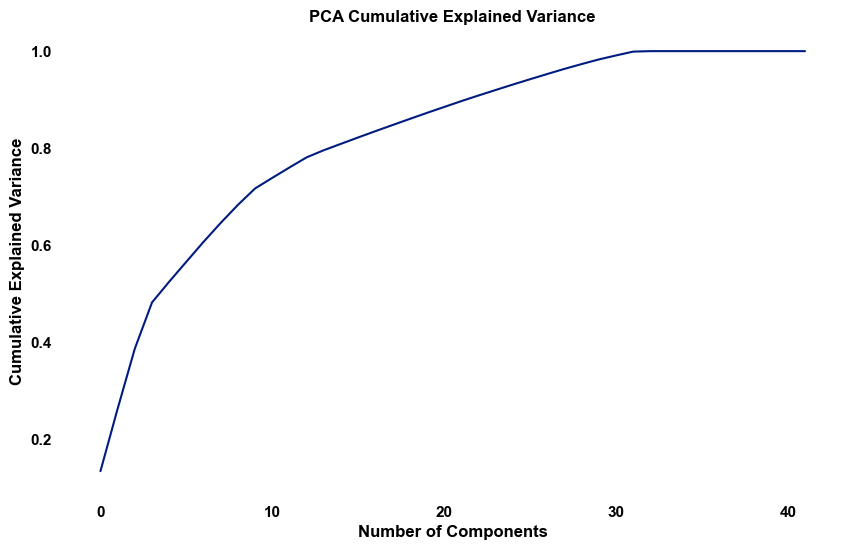

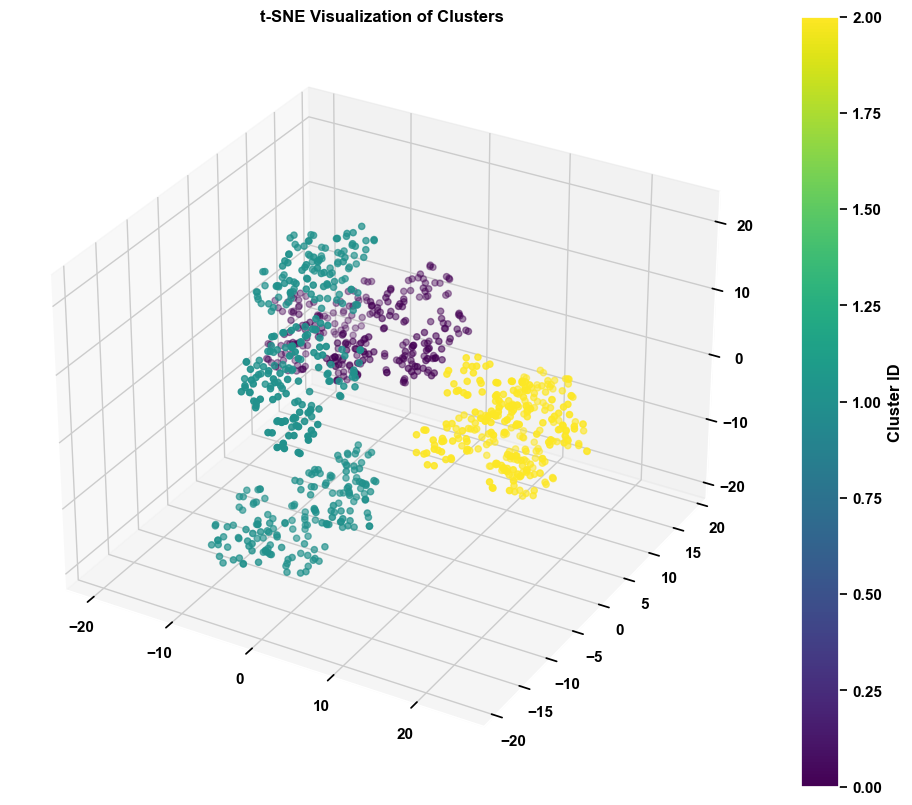


Cluster 0 mean values:
age_boxcox                          4.1731
policy_annual_premium_boxcox     1274.2143
total_claim_amount_boxcox      131893.2901
vehicle_claim_boxcox           106527.4520
dtype: float64
Most common incident_hour_of_the_day in Cluster 0: 23
Most common number_of_vehicles_involved in Cluster 0: 3
Most common bodily_injuries in Cluster 0: 0
Most common witnesses in Cluster 0: 0
Most common auto_year in Cluster 0: 2005


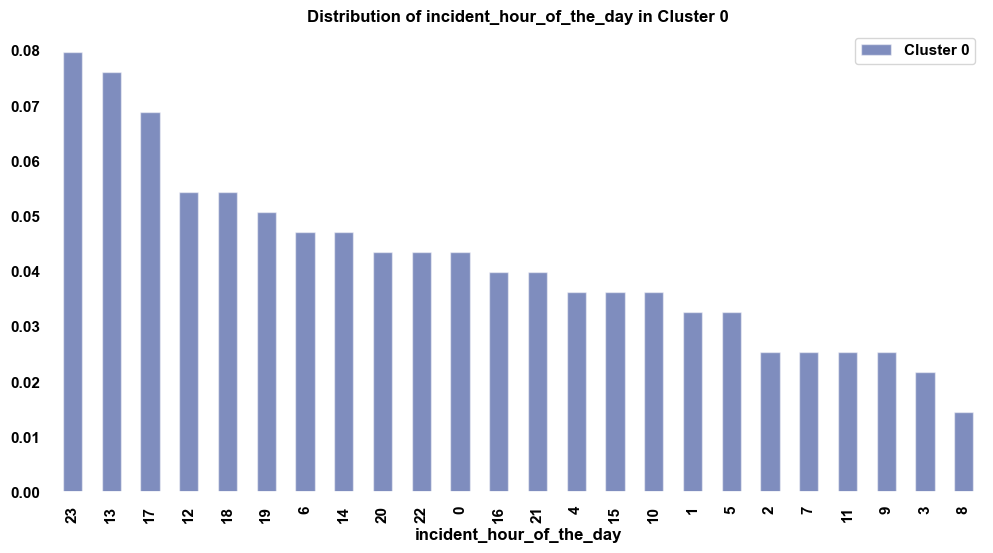

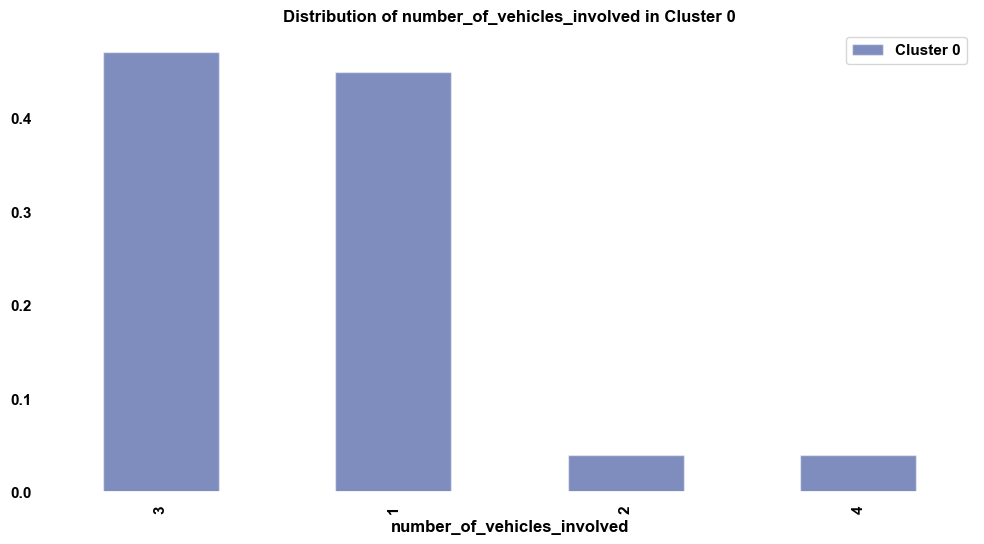

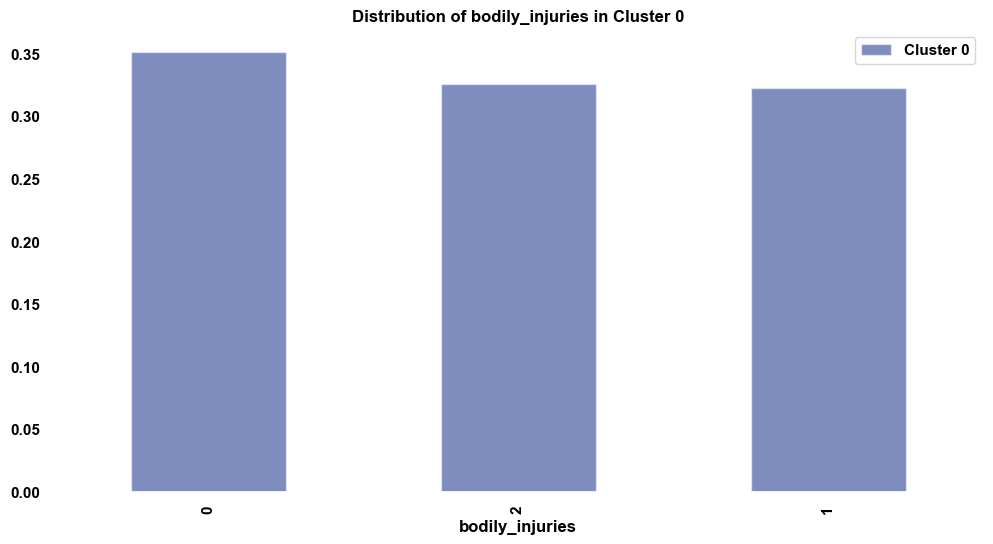

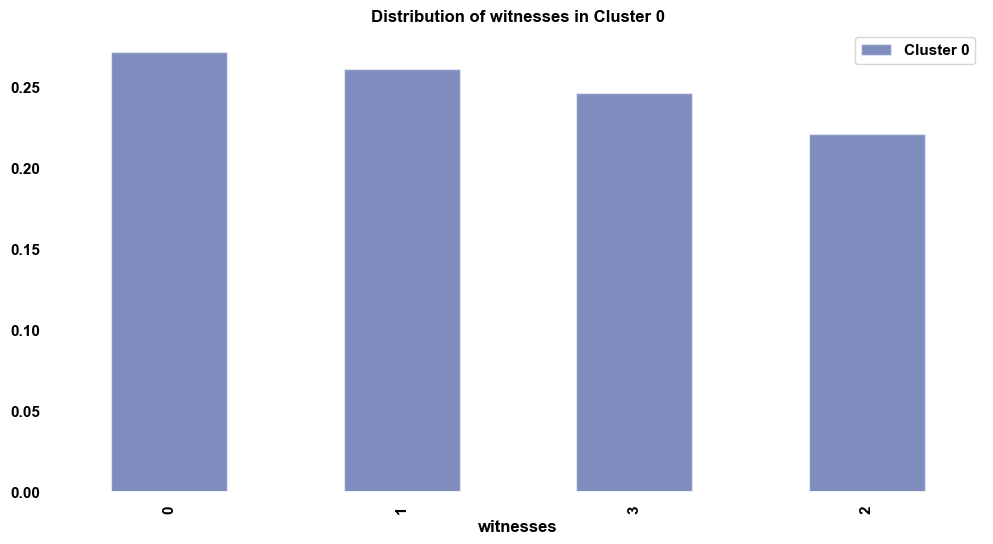

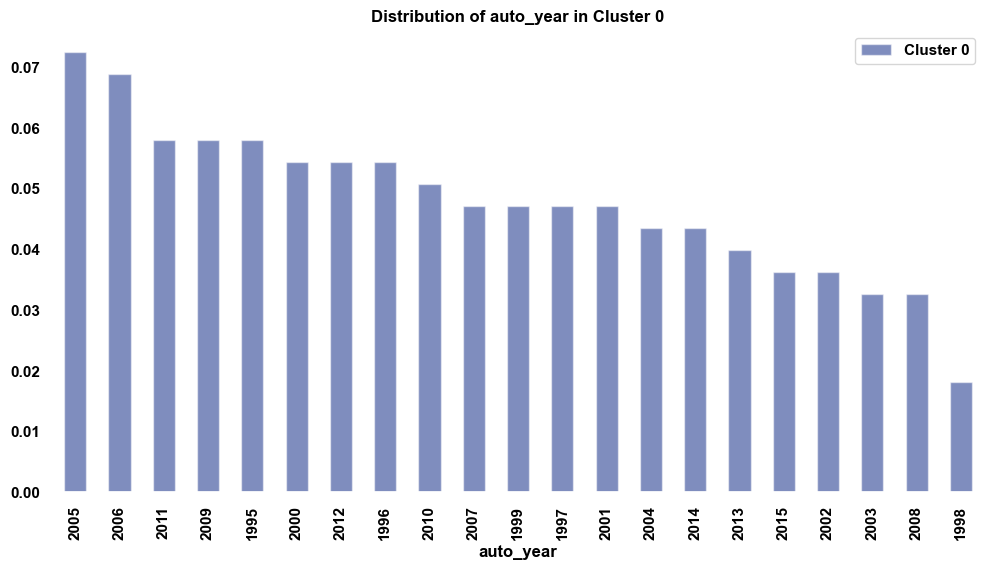


Cluster 1 mean values:
age_boxcox                         4.2027
policy_annual_premium_boxcox    1250.4038
total_claim_amount_boxcox      83790.3471
vehicle_claim_boxcox           67376.0150
dtype: float64
Most common incident_hour_of_the_day in Cluster 1: 3
Most common number_of_vehicles_involved in Cluster 1: 1
Most common bodily_injuries in Cluster 1: 1
Most common witnesses in Cluster 1: 2
Most common auto_year in Cluster 1: 2008


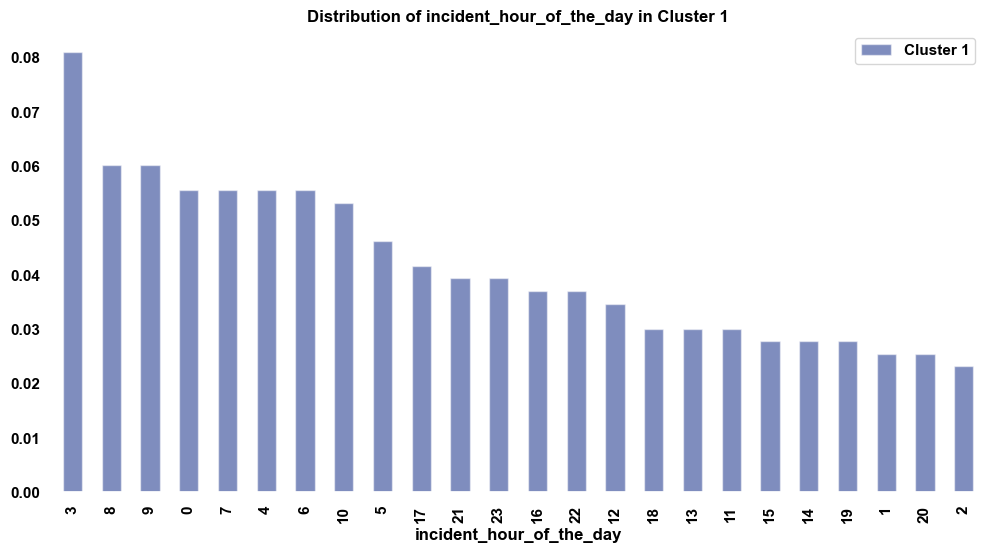

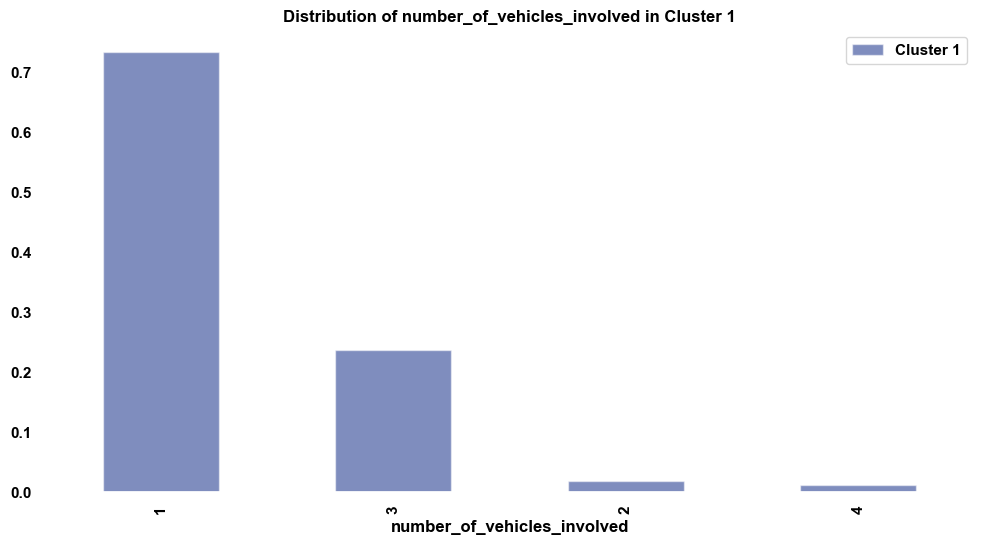

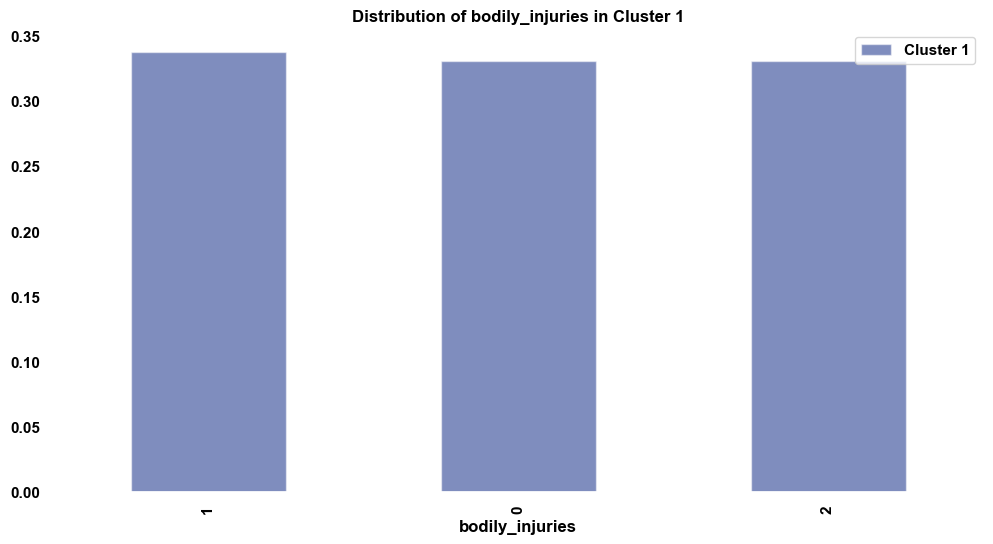

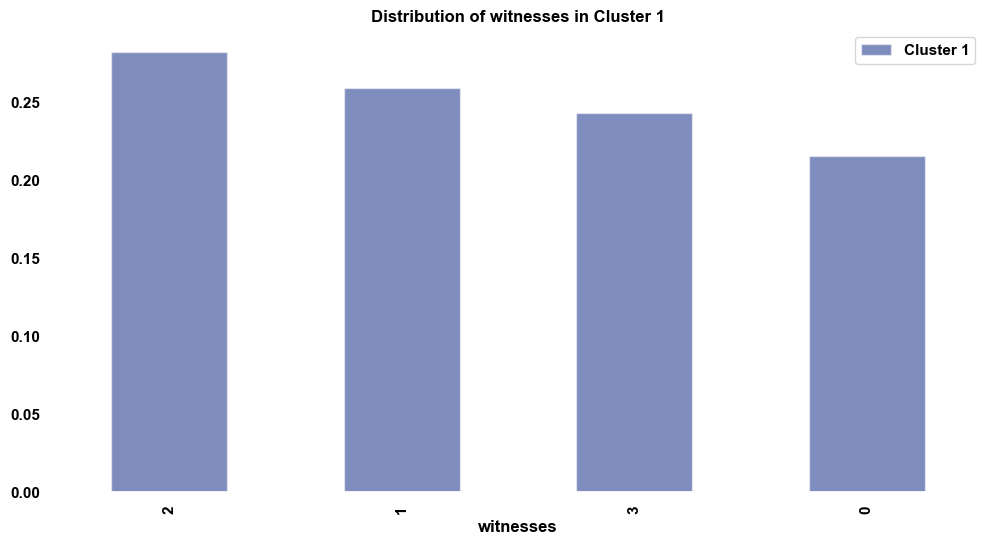

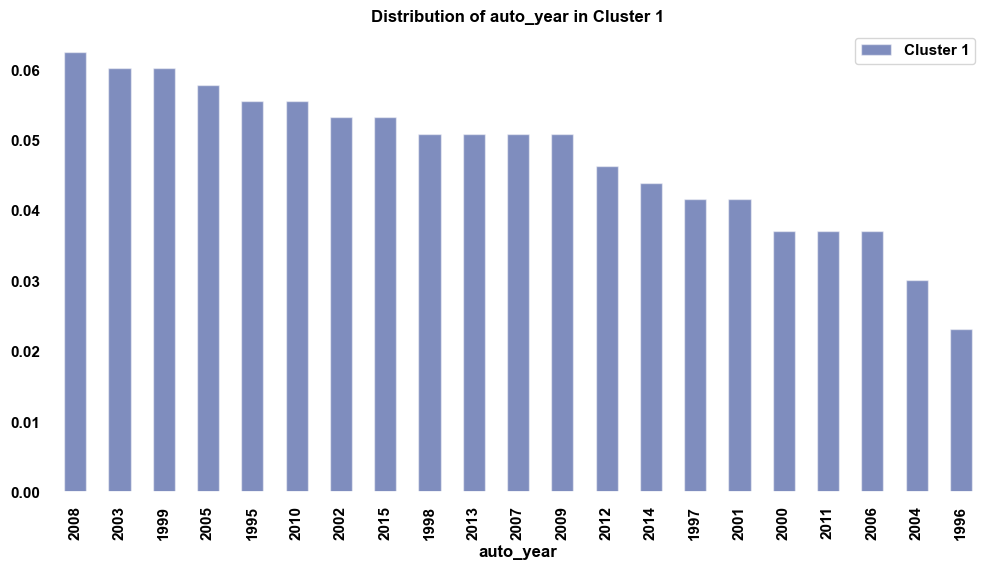


Cluster 2 mean values:
age_boxcox                          4.1675
policy_annual_premium_boxcox     1260.1777
total_claim_amount_boxcox      129184.2113
vehicle_claim_boxcox           103651.1084
dtype: float64
Most common incident_hour_of_the_day in Cluster 2: 16
Most common number_of_vehicles_involved in Cluster 2: 1
Most common bodily_injuries in Cluster 2: 0
Most common witnesses in Cluster 2: 0
Most common auto_year in Cluster 2: 2011


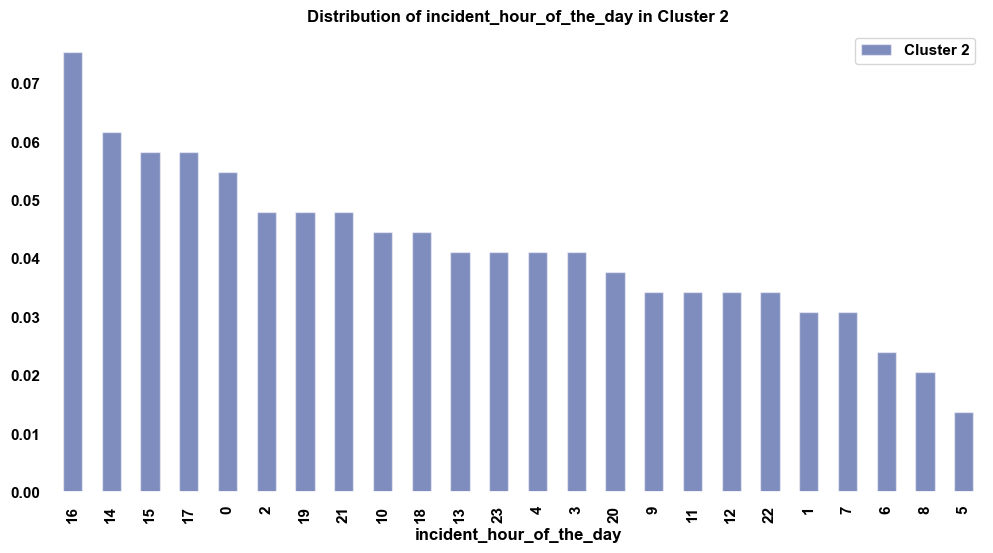

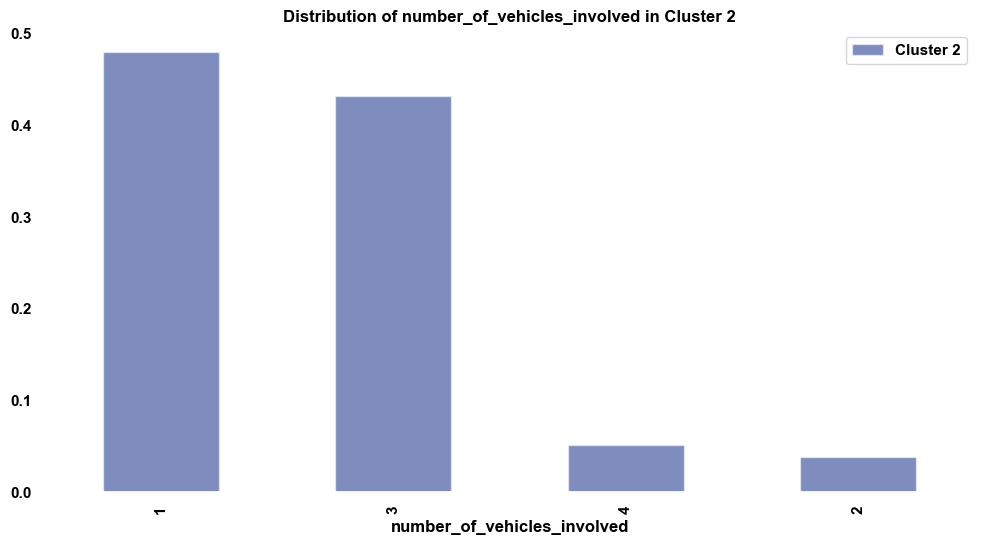

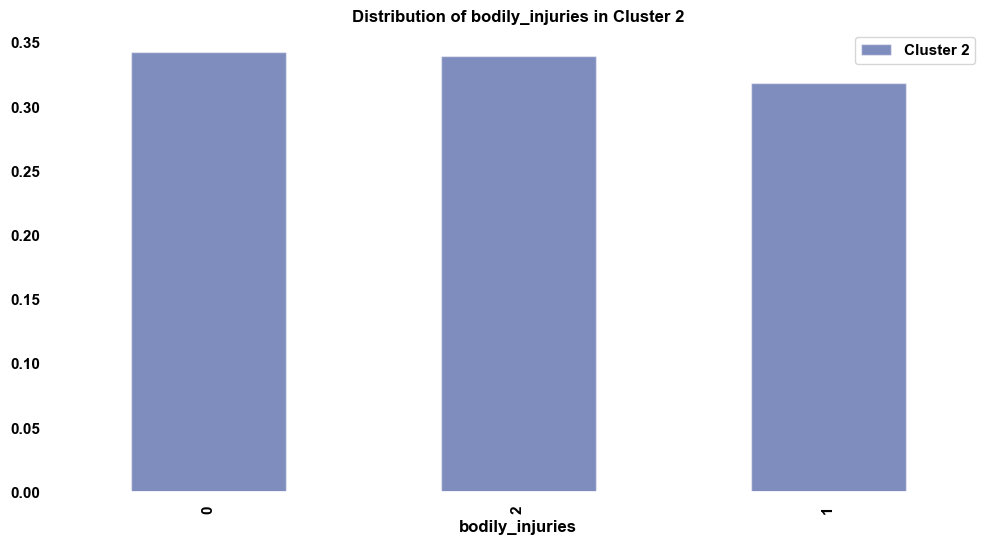

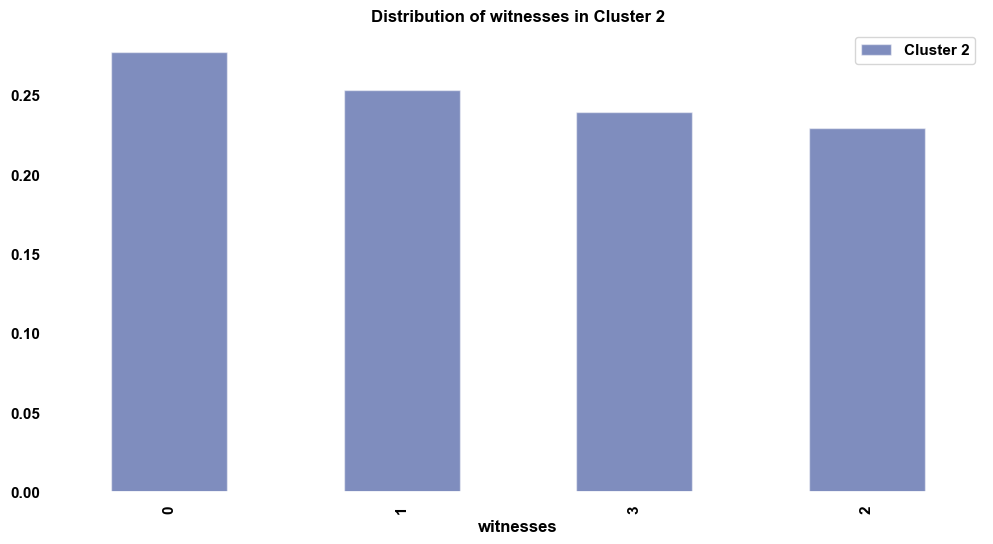

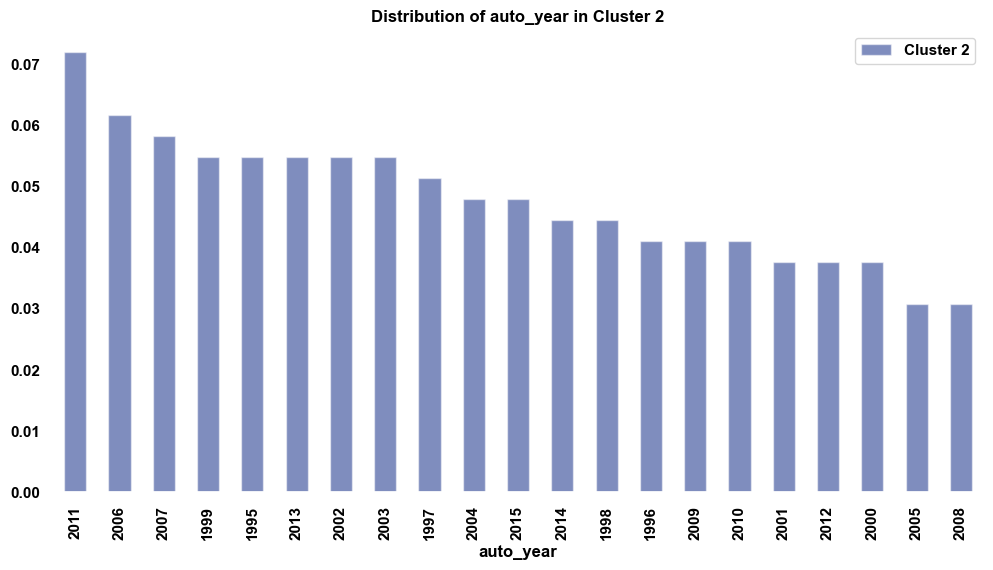

In [33]:
# Ensure continuous_features only contains numerical columns
continuous_features = df1.select_dtypes(include=['int', 'float']).columns.tolist()
categorical_features = df1.select_dtypes(include=['category', 'object']).columns.tolist()

pca = PCA()
pca_result = pca.fit_transform(scaled_dfs['mm_scale'])

# Plot cumulative explained variance ratio
plt.figure(figsize=(10, 6))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('PCA Cumulative Explained Variance')
plt.show()

# t-SNE for visualization
tsne = TSNE(n_components=3, random_state=42)
tsne_result = tsne.fit_transform(scaled_dfs['mm_scale'])

fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(tsne_result[:, 0], tsne_result[:, 1], tsne_result[:, 2], c=labels['mm_scale'], cmap='viridis')
plt.colorbar(scatter, ax=ax, label='Cluster ID')
plt.title('t-SNE Visualization of Clusters')
plt.show()

# Analyze cluster characteristics
for cluster_id in range(3):
    cluster_data = df1[labels['mm_scale'] == cluster_id]
    print(f"\nCluster {cluster_id} mean values:")
    print(cluster_data[continuous_features].mean())
    
    # For categorical features, look at the most common values in each cluster
    for feature in categorical_features:
        most_common = cluster_data[feature].value_counts().index[0]
        print(f"Most common {feature} in Cluster {cluster_id}: {most_common}")

    # Additional analysis: distribution of categorical variables
    for feature in categorical_features:
        plt.figure(figsize=(12, 6))
        cluster_data[feature].value_counts(normalize=True).plot(kind='bar', alpha=0.5, label=f'Cluster {cluster_id}')
        plt.title(f'Distribution of {feature} in Cluster {cluster_id}')
        plt.legend()
        plt.show()

## <span style="color:Aqua;">Creating cluster using the Original Features:</span>


In [34]:
fea1

['months_as_customer',
 'policy_deductable',
 'insured_sex',
 'auto_year',
 'insured_education_level',
 'age_boxcox',
 'collision_type__Front Collision',
 'collision_type__Others',
 'collision_type__Rear Collision',
 'collision_type__Side Collision',
 'insured_hobbies__base-jumping',
 'insured_hobbies__basketball',
 'insured_hobbies__board-games',
 'insured_hobbies__bungie-jumping',
 'insured_hobbies__camping',
 'insured_hobbies__chess',
 'insured_hobbies__cross-fit',
 'insured_hobbies__dancing',
 'insured_hobbies__exercise',
 'insured_hobbies__golf',
 'insured_hobbies__hiking',
 'insured_hobbies__kayaking',
 'insured_hobbies__movies',
 'insured_hobbies__paintball',
 'insured_hobbies__polo',
 'insured_hobbies__reading',
 'insured_hobbies__skydiving',
 'insured_hobbies__sleeping',
 'insured_hobbies__video-games',
 'insured_hobbies__yachting',
 'insured_rela__husband',
 'insured_rela__not-in-family',
 'insured_rela__other-relative',
 'insured_rela__own-child',
 'insured_rela__unmarried',

In [42]:
df1.iloc[0][fea1]

months_as_customer                           328
policy_deductable                           1000
insured_sex                                    1
auto_year                                   2004
insured_education_level                        4
age_boxcox                                4.4951
collision_type__Front Collision                0
collision_type__Others                         0
collision_type__Rear Collision                 0
collision_type__Side Collision                 1
insured_hobbies__base-jumping                  0
insured_hobbies__basketball                    0
insured_hobbies__board-games                   0
insured_hobbies__bungie-jumping                0
insured_hobbies__camping                       0
insured_hobbies__chess                         0
insured_hobbies__cross-fit                     0
insured_hobbies__dancing                       0
insured_hobbies__exercise                      0
insured_hobbies__golf                          0
insured_hobbies__hik

In [43]:
kmeans = KMeans(n_clusters=3, random_state=42)
kmeans.fit(df1[fea1])
df1['Cluster'] = kmeans.predict(df1[fea1])
silhouette = silhouette_score(df1[fea1], kmeans.labels_)
calinski_harabasz = calinski_harabasz_score(df1[fea1], kmeans.labels_)
davies_bouldin = davies_bouldin_score(df1[fea1], kmeans.labels_)

In [44]:
os.makedirs('pkls', exist_ok=True)
with open(r'pkls/K_means.pkl', 'wb') as f:
    pickle.dump(kmeans,f)

In [47]:
df1.iloc[0]['Cluster']

np.int32(1)

In [45]:
print(f"Clusters unique values -- {np.unique(kmeans.labels_)} \nSilhouette Score -- {silhouette} \
      \ncalinski_harabasz Score -- {calinski_harabasz} \ndavies_bouldin -- {davies_bouldin}")

Clusters unique values -- [0 1 2] 
Silhouette Score -- 0.7883181408803311       
calinski_harabasz Score -- 14071.682299877868 
davies_bouldin -- 0.3150950453632872


In [119]:
pd.set_option('display.max_rows', None)  # Display all rows
pd.set_option('display.max_columns', None)  # Display all columns   

# Create DataFrame of cluster centroids
centroids = pd.DataFrame(kmeans.cluster_centers_, columns=fea1)
print("Cluster Centroids:")
# print(centroids)

# Calculate feature-wise variance across clusters
cluster_variance = np.var(kmeans.cluster_centers_, axis=0)

# Calculate silhouette score
silhouette_avg = silhouette_score(df1[fea1], kmeans.labels_)
print("Silhouette Score:", silhouette_avg)

# Combine feature variance and silhouette score
importance = pd.DataFrame({'Feature': fea1, 'Cluster Variance': cluster_variance, 'Silhouette Score': silhouette_avg})
importance = importance.sort_values(by=['Cluster Variance', 'Silhouette Score'], ascending=[False, True])

print("Feature Importance:")
print(importance)

Cluster Centroids:
Silhouette Score: 0.7883181408803311
Feature Importance:
                                    Feature  Cluster Variance  \
1                         policy_deductable       388888.8889   
0                        months_as_customer           31.0153   
3                                 auto_year            0.0262   
4                   insured_education_level            0.0018   
36   incident_type__Multi-vehicle Collision            0.0009   
6           collision_type__Front Collision            0.0007   
38  incident_type__Single Vehicle Collision            0.0007   
35                       insured_rela__wife            0.0005   
32             insured_rela__other-relative            0.0004   
9            collision_type__Side Collision            0.0003   
5                                age_boxcox            0.0003   
28             insured_hobbies__video-games            0.0003   
14                 insured_hobbies__camping            0.0002   
37            

In [120]:
kmeans = KMeans(n_clusters=3, random_state=42)
kmeans.fit(df1[fea1])
df['Cluster'] = kmeans.predict(df1[fea1])
silhouette = silhouette_score(df1[fea1], kmeans.labels_)
calinski_harabasz = calinski_harabasz_score(df1[fea1], kmeans.labels_)
davies_bouldin = davies_bouldin_score(df1[fea1], kmeans.labels_)

In [121]:
df1.to_feather('clustered.feather')

In [122]:
df['Cluster'] =df1['Cluster']

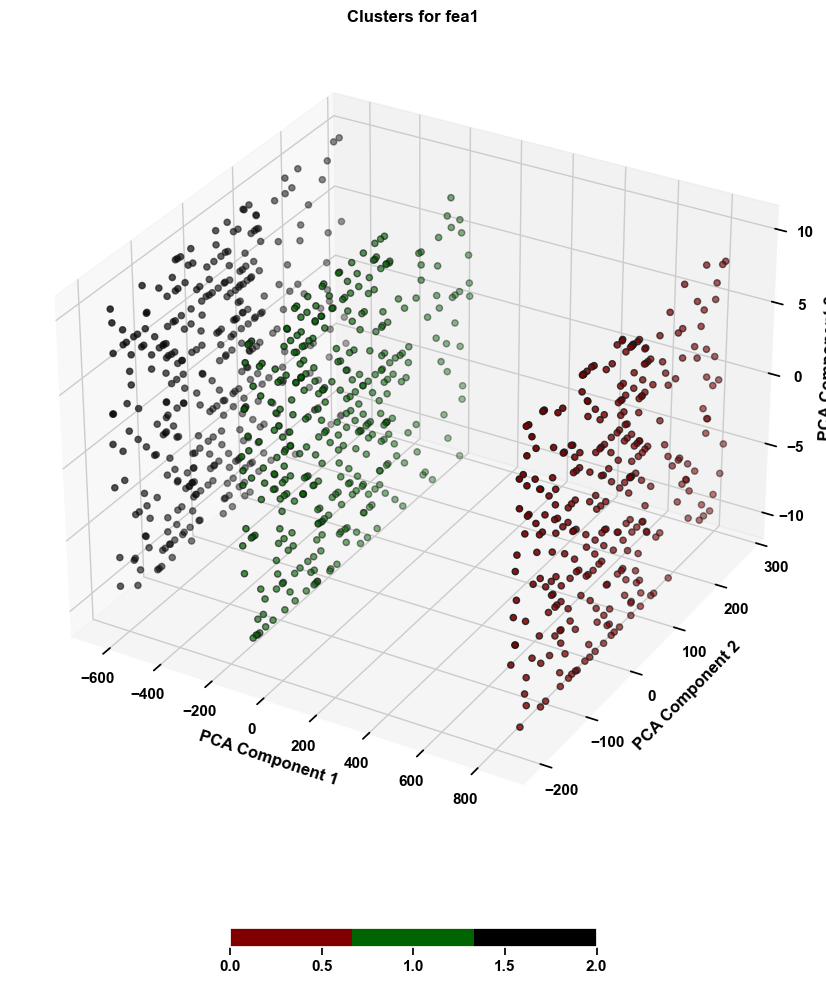

In [123]:
# Create a figure for 3D plotting
fig = plt.figure(figsize=(10, 10))

# Add a 3D subplot
ax = fig.add_subplot(111, projection='3d')

# Perform PCA
pca = PCA(n_components=3)
x_pca = pca.fit_transform(df1[fea1])

# Run KMeans
kmeans = KMeans(n_clusters=3, init='k-means++', random_state=42)
labels = kmeans.fit_predict(df1[fea1])

# Define custom colors for clusters
import matplotlib.colors as mcolors
colors = ['maroon', 'darkgreen', 'black']
cmap = mcolors.ListedColormap(colors)

# Create a 3D scatter plot
scatter = ax.scatter(x_pca[:, 0], x_pca[:, 1], x_pca[:, 2], c=labels, cmap=cmap, marker='o', edgecolor='k')

# Set title and axis labels
ax.set_title('Clusters for fea1')
ax.set_xlabel('PCA Component 1')
ax.set_ylabel('PCA Component 2')
ax.set_zlabel('PCA Component 3')

# Add color bar
fig.colorbar(scatter, ax=ax, orientation='horizontal', fraction=0.02, pad=0.1)

# Show the plot
plt.tight_layout()
plt.show()

# <span style="color:Tomato;">Results Interpretation:</span>

- <span style="color:Aqua;"> Algorithm: </span> KMeans with n_clusters=2.
- <span style="color:Aqua;"> Metrics: </span>
    - <span style="color:Khaki;">Silhouette Score:</span> 0.679 (indicates good cluster separation).
    - <span style="color:Khaki;">Calinski-Harabasz Score:</span> 2443.515 (suggests well-separated and dense clusters).
    - <span style="color:Khaki;">Davies-Bouldin Score:</span> 0.402 (indicates well-separated clusters).
- <span style="color:Aqua;"> Cluster Characteristics:</span>
    - <span style="color:Khaki;">Cluster 0:</span> Higher values in features such as incident_hour_of_the_day, number_of_vehicles_involved, and bodily_injuries.
    - <span style="color:Khaki;"> Cluster 1:</span> Lower values in these features.
- <span style="color:Aqua;"> Cluster Analysis:</span> Shows distinct patterns between clusters, useful for segmenting policyholders.

## <span style="color:Aqua;">Clusters Summary:</span>

In [124]:
cluster_centroids = df.select_dtypes(include='number').groupby('Cluster').mean()
cluster_centroids

months_as_customer  policy_deductable  insured_sex  \
Cluster                                                       
0                  210.6678          2000.0000       0.4593   
1                  197.0855          1000.0000       0.4558   
2                  204.9766           500.0000       0.4737   

         insured_education_level  incident_severity  property_damage  \
Cluster                                                                
0                         3.0228             1.1498           0.6612   
1                         2.9202             1.2222           0.6467   
2                         2.9620             1.1754           0.6579   

         police_report_available  fraud_reported  age_boxcox  \
Cluster                                                        
0                         0.3779          0.2638      4.2048   
1                         0.3618          0.2251      4.1627   
2                         0.3509          0.2544      4.1880   

         policy_annual_premium_boxcox  total_claim_amount_boxcox  \
Cluster                                                            
0                           1255.6167                113063.6933   
1                           1268.1099                107774.8565   
2                           1255.1129                110474.3838   

         injury_claim_cube  property_claim_cube  vehicle_claim_boxcox  \
Cluster                                                                 
0               -2273.4853           -1160.6254            89664.8311   
1               -1020.0114           -1035.8974            87218.6477   
2                -545.2632             517.9415            89571.0245   

         insurance_age  vehicle_age  
Cluster                              
0              13.8502       9.6645  
1              13.4758       9.9601  
2              12.9064      10.0409

In [125]:
cluster_centroids = df.groupby('Cluster').describe(exclude='number')
cluster_centroids

policy_bind_date                                                  \
                   count unique  top freq                           mean   
Cluster                                                                    
0                    307    NaN  NaN  NaN  2001-08-21 15:19:20.912052096   
1                    351    NaN  NaN  NaN  2002-01-12 23:51:47.692307712   
2                    342    NaN  NaN  NaN  2002-08-07 04:29:28.421052672   

                                                                        \
                         min                  25%                  50%   
Cluster                                                                  
0        1990-01-27 00:00:00  1995-09-01 12:00:00  2001-01-02 00:00:00   
1        1990-02-03 00:00:00  1995-03-11 00:00:00  2002-04-01 00:00:00   
2        1990-01-08 00:00:00  1996-02-27 12:00:00  2002-09-03 00:00:00   

                                                  policy_state             \
                         75%                  max        count unique top   
Cluster                                                                     
0        2007-08-24 00:00:00  2015-01-17 00:00:00          307      3  OH   
1        2007-10-26 12:00:00  2015-02-22 00:00:00          351      3  OH   
2        2009-05-09 18:00:00  2015-01-03 00:00:00          342      3  OH   

                                           insured_occupation         \
        freq mean  min  25%  50%  75%  max              count unique   
Cluster                                                                
0        116  NaN  NaN  NaN  NaN  NaN  NaN                307     14   
1        118  NaN  NaN  NaN  NaN  NaN  NaN                351     14   
2        118  NaN  NaN  NaN  NaN  NaN  NaN                342     14   

                                                              insured_hobbies  \
                       top freq mean  min  25%  50%  75%  max           count   
Cluster                                                                         
0                    sales   27  NaN  NaN  NaN  NaN  NaN  NaN             307   
1        machine-op-inspct   39  NaN  NaN  NaN  NaN  NaN  NaN             351   
2           prof-specialty   42  NaN  NaN  NaN  NaN  NaN  NaN             342   

                                                                \
        unique          top freq mean  min  25%  50%  75%  max   
Cluster                                                          
0           20  video-games   23  NaN  NaN  NaN  NaN  NaN  NaN   
1           20      camping   26  NaN  NaN  NaN  NaN  NaN  NaN   
2           20      reading   25  NaN  NaN  NaN  NaN  NaN  NaN   

        insured_relationship                                                  \
                       count unique             top freq mean  min  25%  50%   
Cluster                                                                        
0                        307      6       own-child   59  NaN  NaN  NaN  NaN   
1                        351      6  other-relative   71  NaN  NaN  NaN  NaN   
2                        342      6            wife   63  NaN  NaN  NaN  NaN   

                  incident_date                   \
         75%  max         count unique  top freq   
Cluster                                            
0        NaN  NaN           307    NaN  NaN  NaN   
1        NaN  NaN           351    NaN  NaN  NaN   
2        NaN  NaN           342    NaN  NaN  NaN   

                                                             \
                                  mean                  min   
Cluster                                                       
0        2015-01-29 14:41:49.446254080  2015-01-01 00:00:00   
1                  2015-01-30 00:53:20  2015-01-01 00:00:00   
2        2015-01-31 06:56:50.526315776  2015-01-01 00:00:00   

                                                                        \
                         25%                  50%                  75%   
Clust

In [126]:
print(df.incident_date.dtype,df.policy_bind_date.dtype)

datetime64[ns] datetime64[ns]


In [127]:
cat_cols = df.select_dtypes(exclude=['number','datetime64[ns]']).columns
cat_cols

Index(['policy_state', 'insured_occupation', 'insured_hobbies',
       'insured_relationship', 'incident_type', 'collision_type',
       'authorities_contacted', 'incident_state', 'incident_city',
       'incident_hour_of_the_day', 'number_of_vehicles_involved',
       'bodily_injuries', 'witnesses', 'auto_make', 'auto_year'],
      dtype='object')

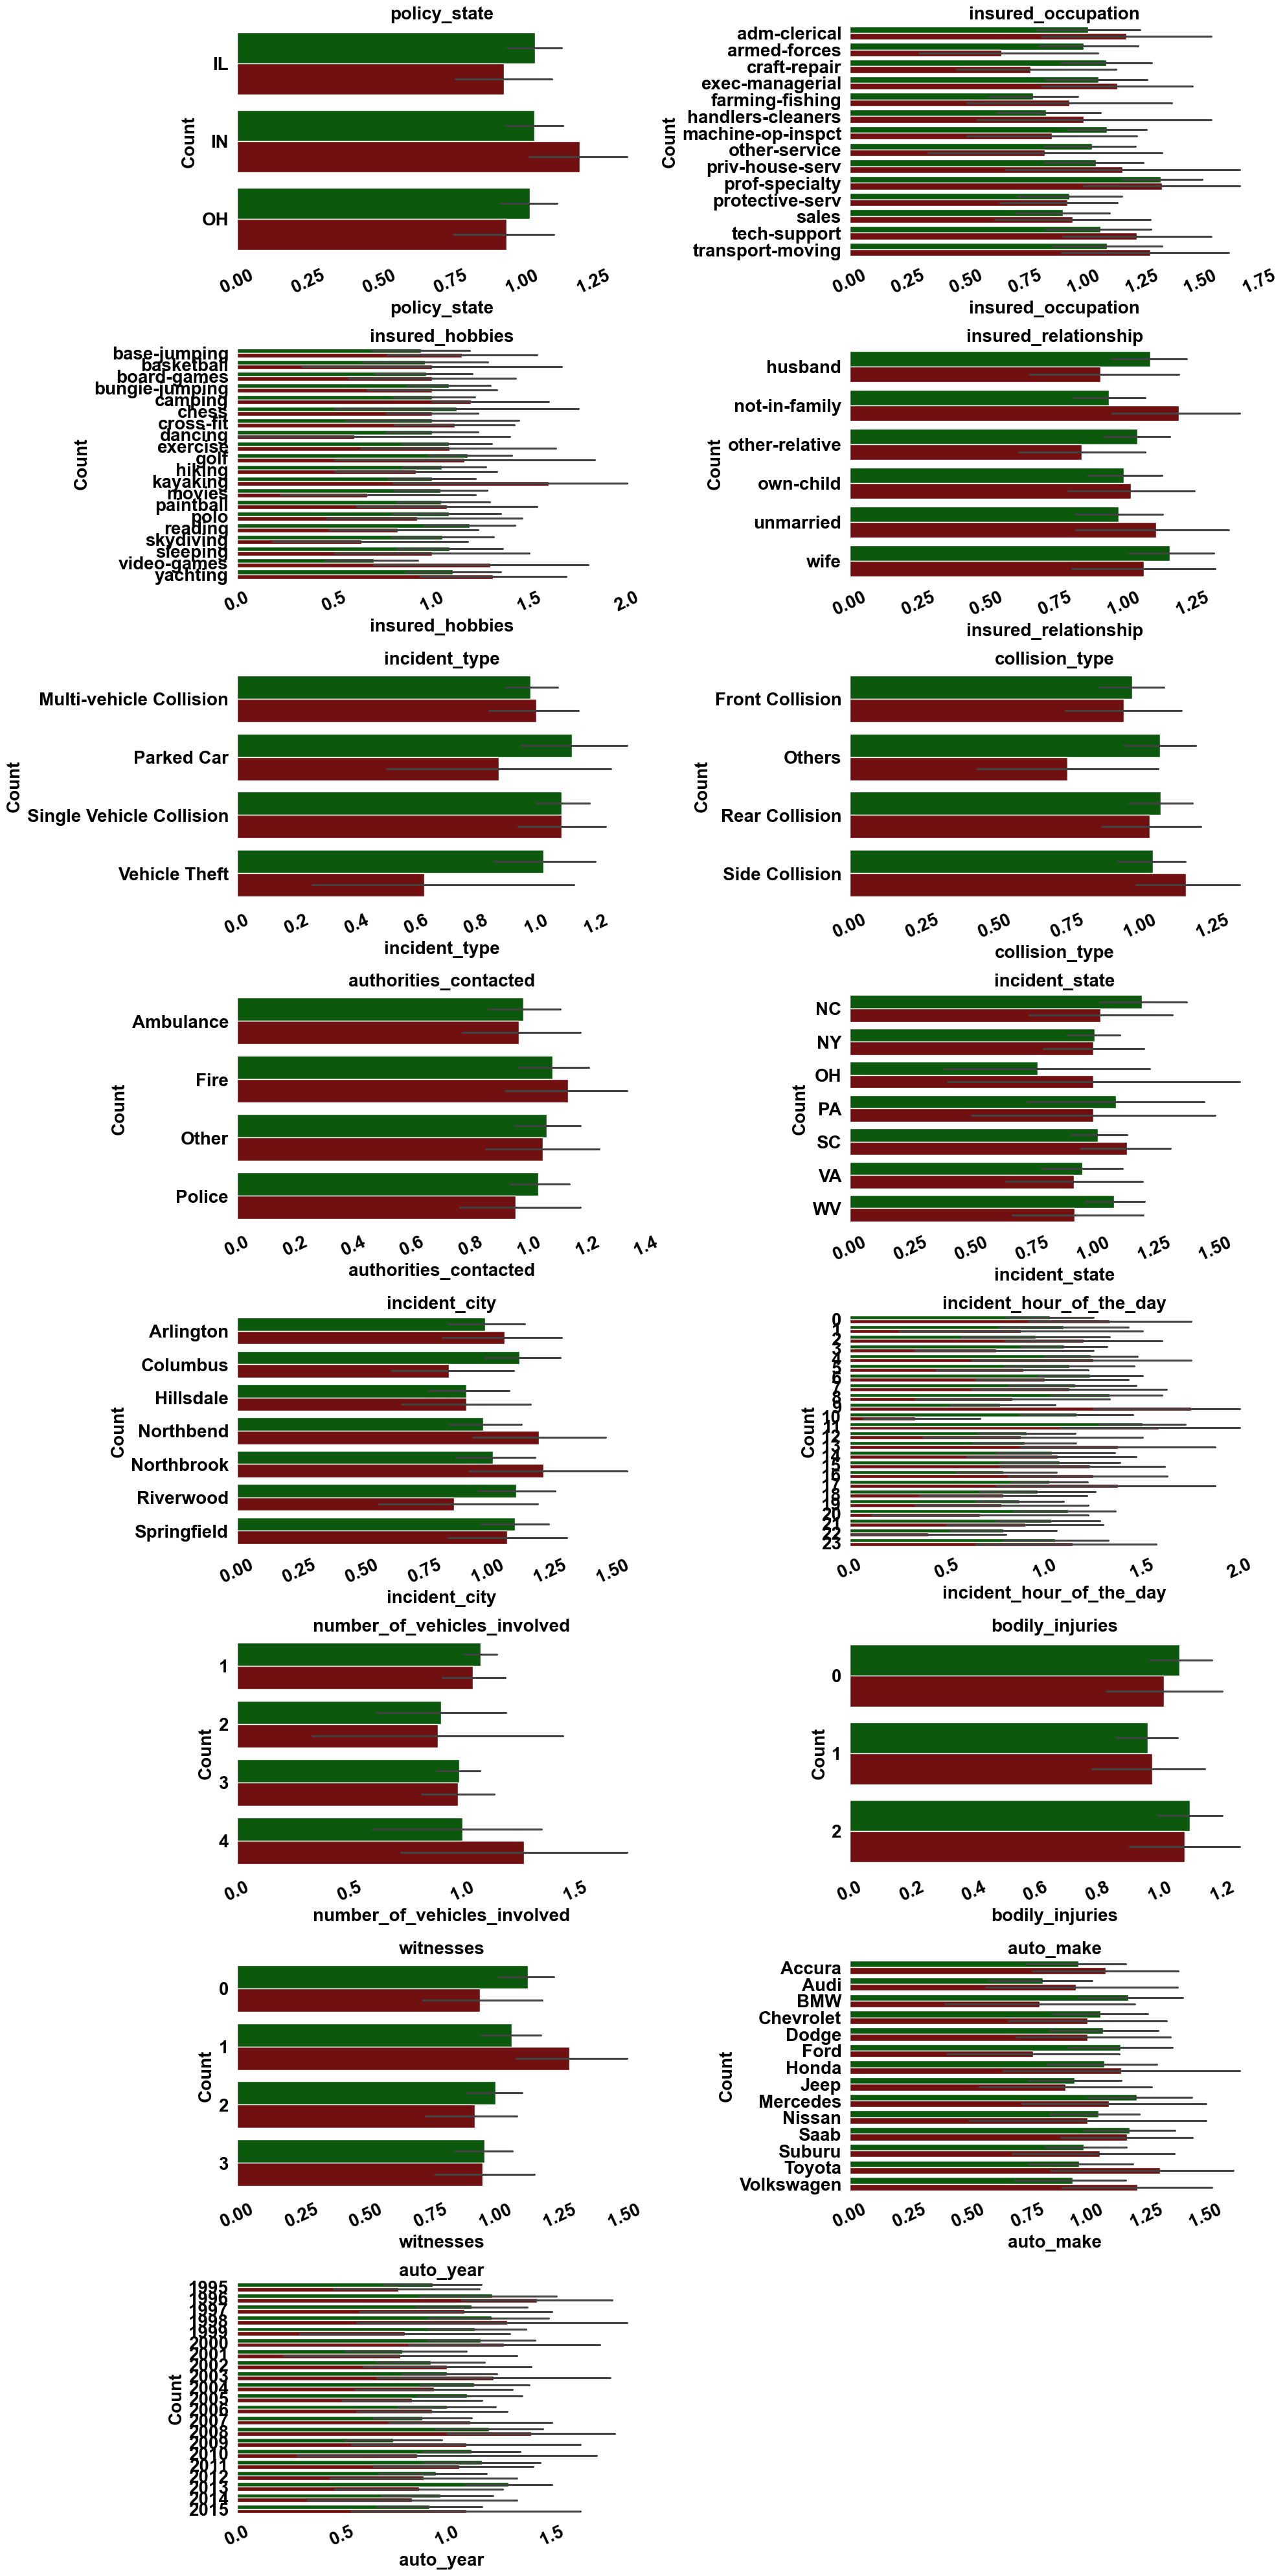

In [128]:
# Select categorical columns
cat_cols = df.select_dtypes(exclude=['number','datetime64[ns]']).columns


# Calculate number of rows needed
num_plots = len(cat_cols)
num_rows = int(np.ceil(num_plots / 2))

# Create subplots with appropriate figsize
fig, axes = plt.subplots(ncols=2, nrows=num_rows, figsize=(20, num_rows * 5))
axes = axes.flatten()

# Plot each numeric column
for i, col in enumerate(cat_cols):

    sns.barplot(data=df, y=col, x='Cluster',  ax=axes[i],hue='fraud_reported',hue_order=[0,1],legend=False,palette=['DarkGreen','maroon'])
    axes[i].set_title(col, fontdict={'fontsize': 20, 'fontweight': 'bold'})
    axes[i].tick_params(axis='x', rotation=25, labelsize=20)
    axes[i].tick_params(axis='y', labelsize=20)
    axes[i].set_xlabel(col, fontsize=20, weight='bold')
    axes[i].set_ylabel('Count', fontsize=20, weight='bold')

# Turn off any unused subplots
for j in range(i + 1, len(axes)):
    axes[j].set_visible(False)

plt.tight_layout()
plt.show()

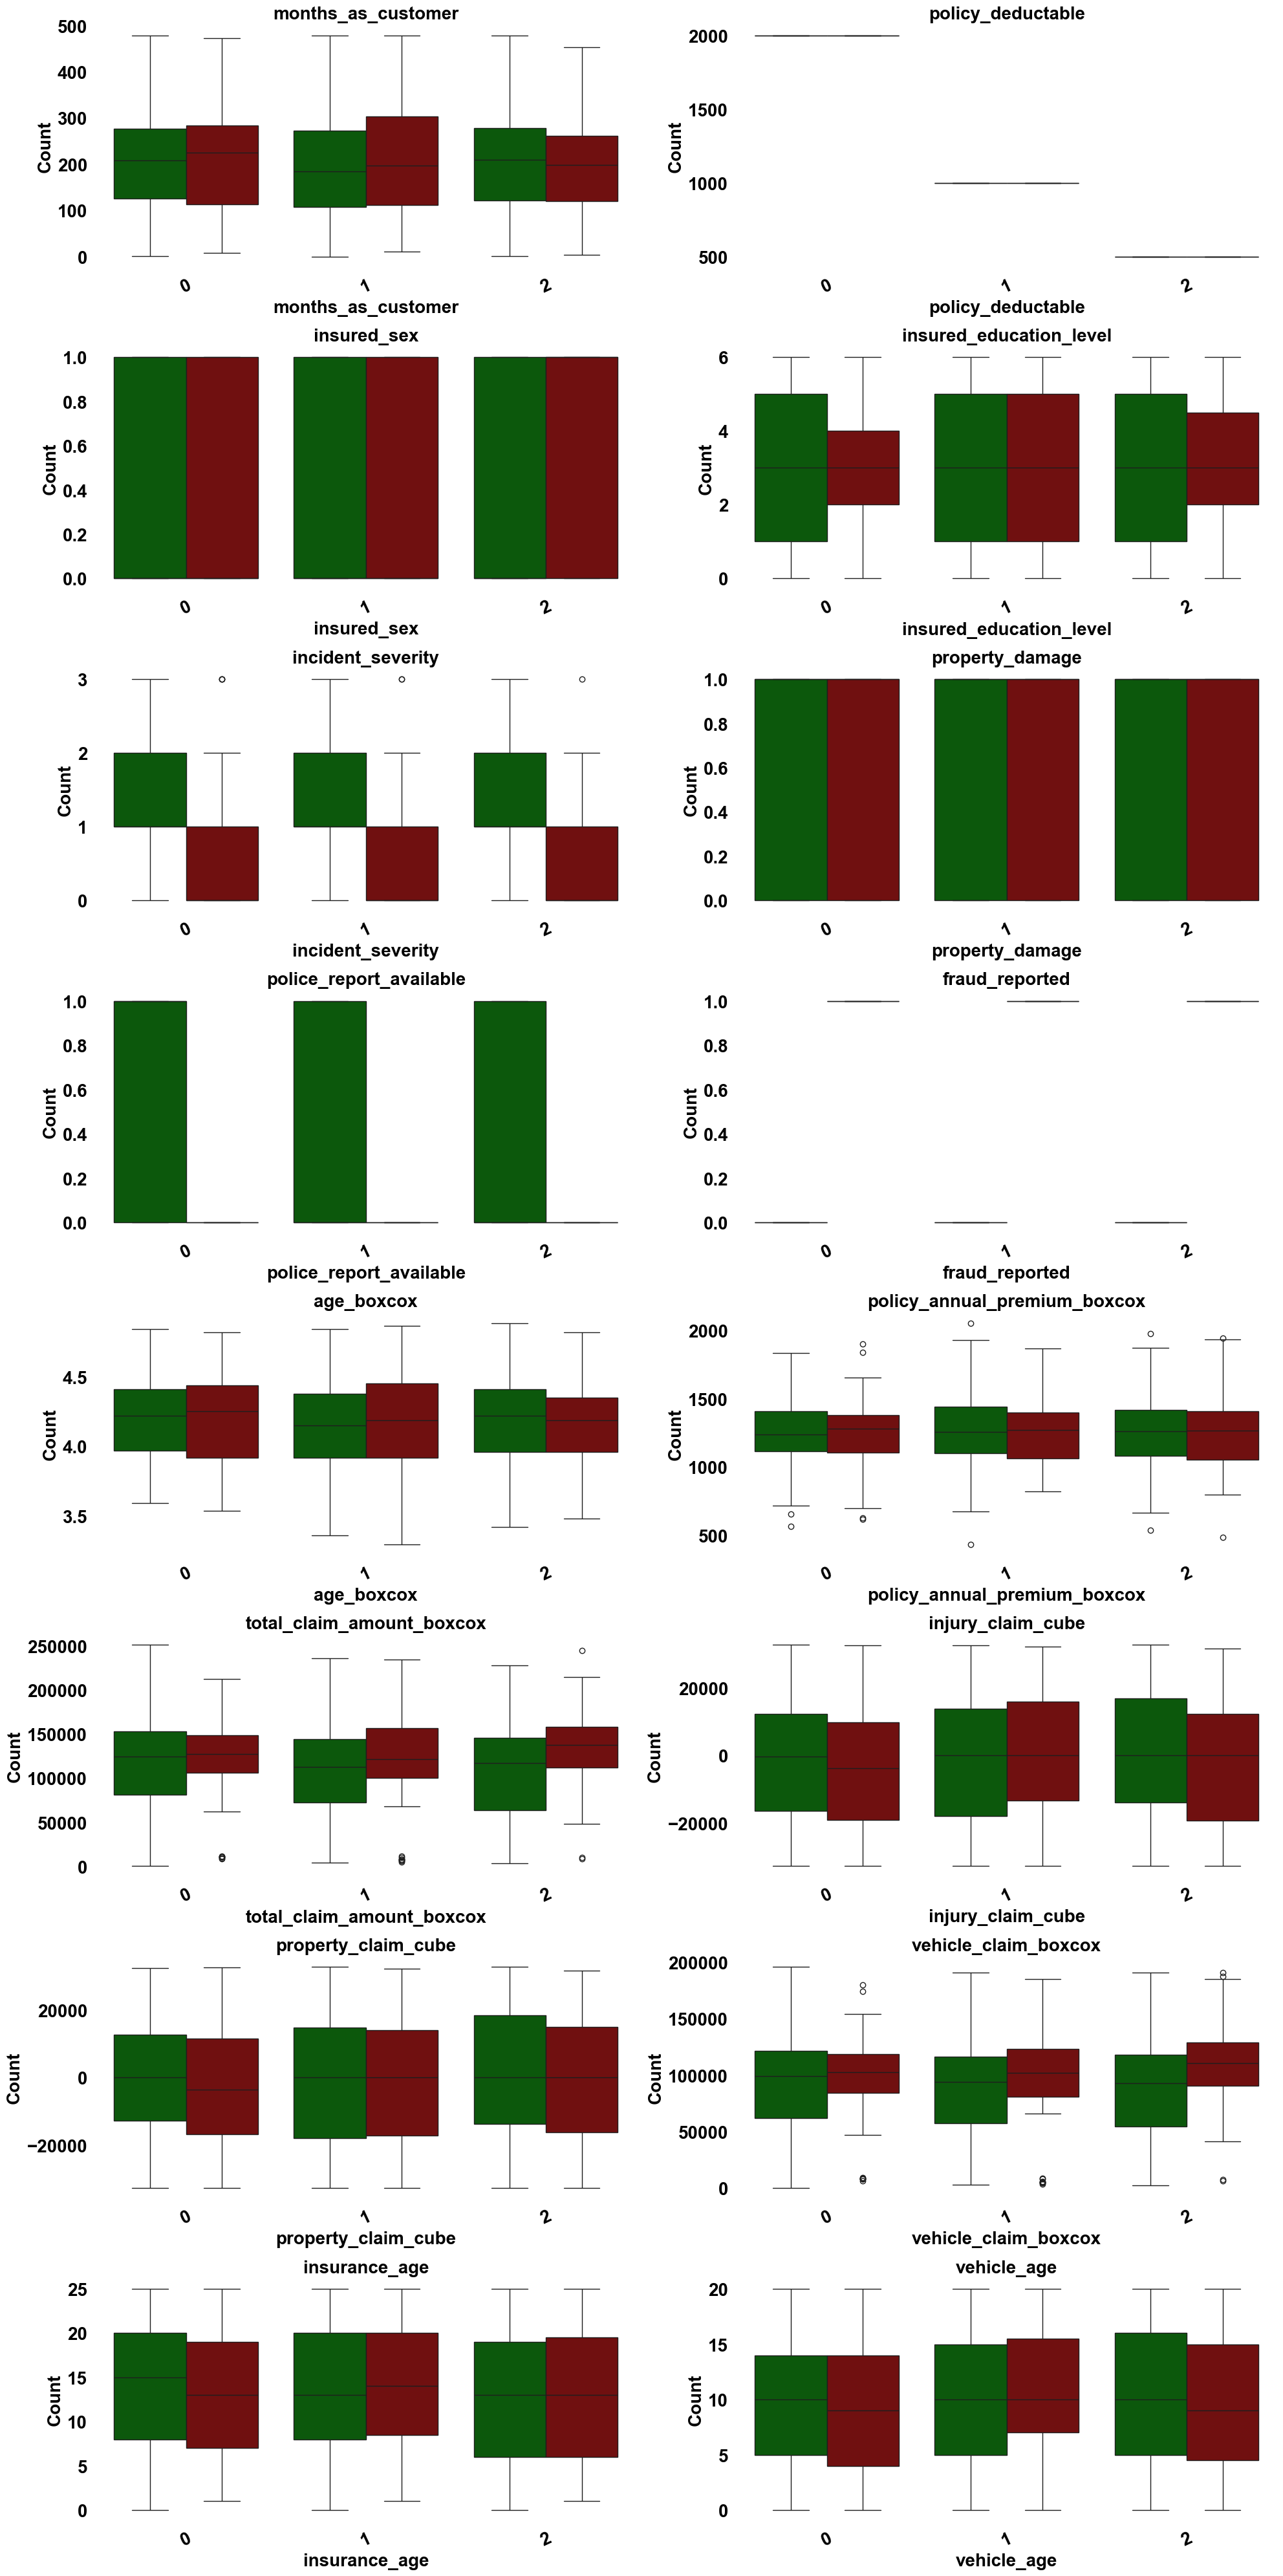

In [129]:
# Select numeric columns, excluding 'Cluster'
numeric_columns = df.select_dtypes(include='number').columns

if 'Cluster' in numeric_columns:
    numeric_columns = numeric_columns.drop('Cluster')

# Calculate number of rows needed
num_plots = len(numeric_columns)
num_rows = int(np.ceil(num_plots / 2))

# Create subplots with appropriate figsize
fig, axes = plt.subplots(ncols=2, nrows=num_rows, figsize=(20, num_rows * 5))
axes = axes.flatten()

# Plot each numeric column
for i, col in enumerate(numeric_columns):
    sns.boxplot(x='Cluster', y=col, data=df,hue='fraud_reported',hue_order=[0,1],legend=False,palette=['DarkGreen','maroon'] ,ax=axes[i])
    axes[i].set_title(col, fontdict={'fontsize': 20, 'fontweight': 'bold'})
    axes[i].tick_params(axis='x', rotation=25, labelsize=20)
    axes[i].tick_params(axis='y', labelsize=20)
    axes[i].set_xlabel(col, fontsize=20, weight='bold')
    axes[i].set_ylabel('Count', fontsize=20, weight='bold')

# Turn off any unused subplots
for j in range(i + 1, len(axes)):
    axes[j].set_visible(False)

plt.tight_layout()
plt.show()

In [130]:
from scipy.stats import mannwhitneyu


# Define significance thresholds
extreme_threshold = 0.001
moderate_threshold = 0.05

# Iterate through each feature
for feature in df1.select_dtypes(exclude=['datetime64[ns]']).columns:
    # Get the data for each cluster
    cluster0 = df1[df1['Cluster'] == 0][feature]
    cluster1 = df1[df1['Cluster'] == 1][feature]
    cluster2 = df1[df1['Cluster'] == 2][feature]

    # Perform pairwise Mann-Whitney U tests and determine significance for each comparison
    comparisons = [
        (cluster0, cluster1, 'Cluster 0 vs. Cluster 1'),
        (cluster0, cluster2, 'Cluster 0 vs. Cluster 2'),
        (cluster1, cluster2, 'Cluster 1 vs. Cluster 2')
    ]
    
    for data1, data2, comparison_name in comparisons:
        stat, p_value = mannwhitneyu(data1, data2, alternative='two-sided')

        # Determine the significance level
        if p_value <= extreme_threshold:
            color = 'green'
            significance = 'Extreme Significance'
        elif p_value <= moderate_threshold:
            color = 'magenta'
            significance = 'Moderate Significance'
        else:
            color = 'red'
            significance = 'No Significance'
        
        # Print the results with color coding
        print(colored(f'{feature} - {comparison_name}: U-stat={stat:.4f}, p-value={p_value:.4f} ({significance})', color))


months_as_customer - Cluster 0 vs. Cluster 1: U-stat=57401.0000, p-value=0.1477 (No Significance)
months_as_customer - Cluster 0 vs. Cluster 2: U-stat=53932.0000, p-value=0.5475 (No Significance)
months_as_customer - Cluster 1 vs. Cluster 2: U-stat=57537.5000, p-value=0.3460 (No Significance)
policy_deductable - Cluster 0 vs. Cluster 1: U-stat=107757.0000, p-value=0.0000 (Extreme Significance)
policy_deductable - Cluster 0 vs. Cluster 2: U-stat=104994.0000, p-value=0.0000 (Extreme Significance)
policy_deductable - Cluster 1 vs. Cluster 2: U-stat=120042.0000, p-value=0.0000 (Extreme Significance)
insured_sex - Cluster 0 vs. Cluster 1: U-stat=54064.0000, p-value=0.9298 (No Significance)
insured_sex - Cluster 0 vs. Cluster 2: U-stat=51741.0000, p-value=0.7139 (No Significance)
insured_sex - Cluster 1 vs. Cluster 2: U-stat=58950.0000, p-value=0.6381 (No Significance)
insured_education_level - Cluster 0 vs. Cluster 1: U-stat=55534.5000, p-value=0.4916 (No Significance)
insured_education_lev

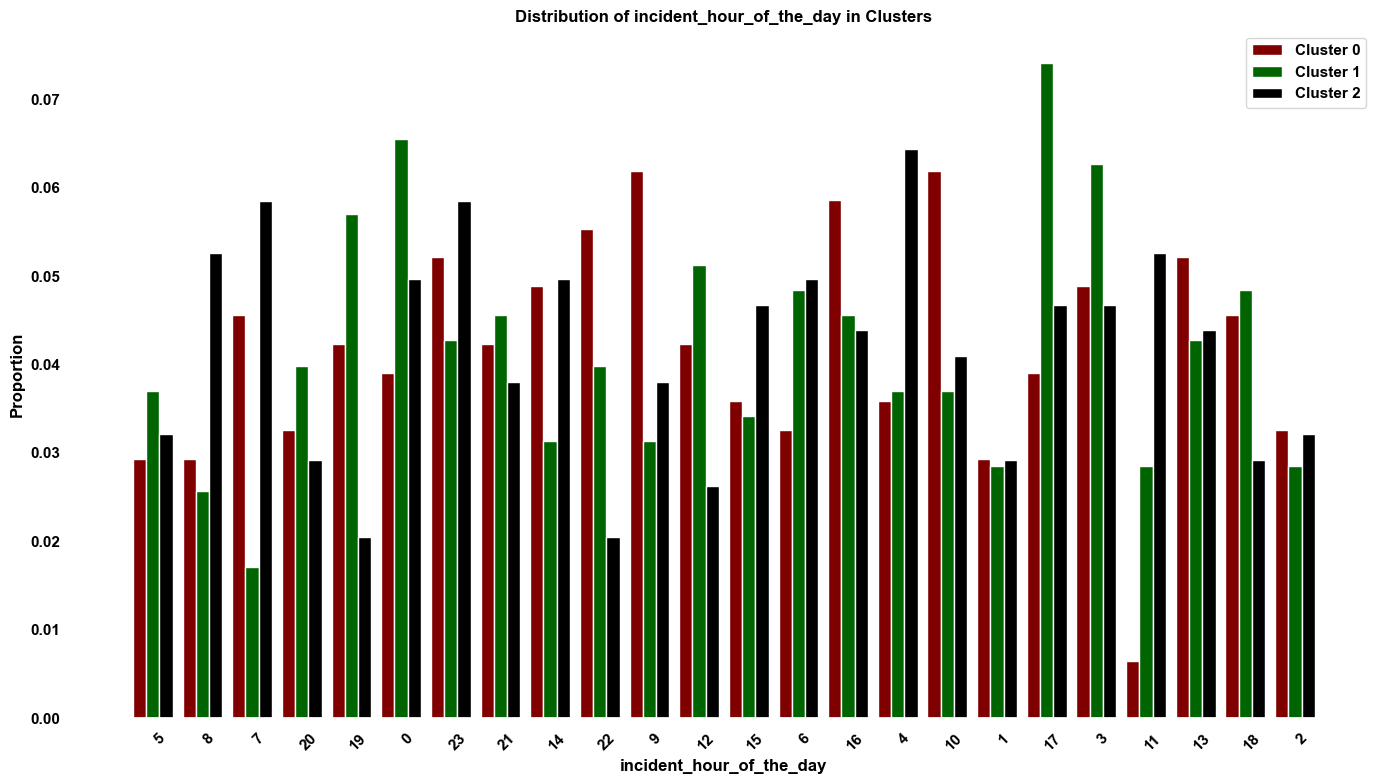

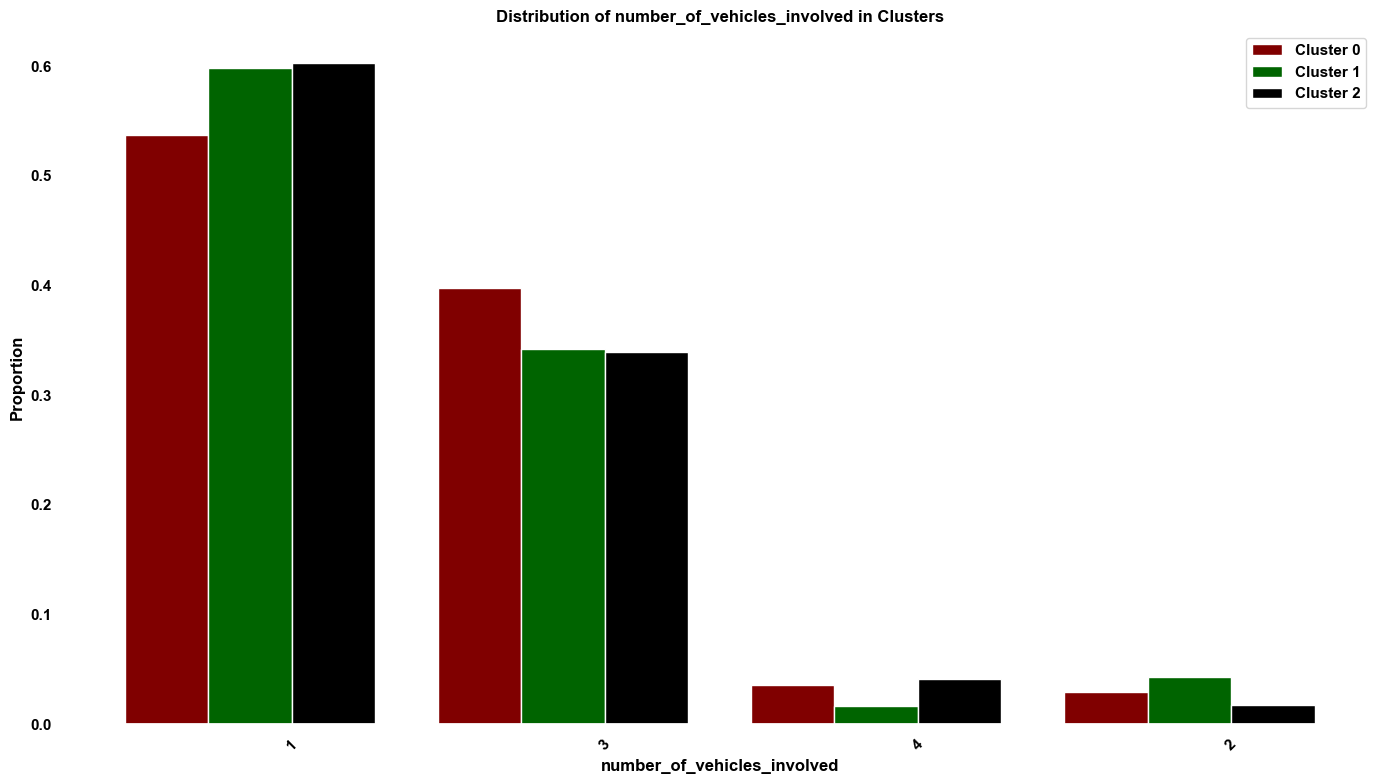

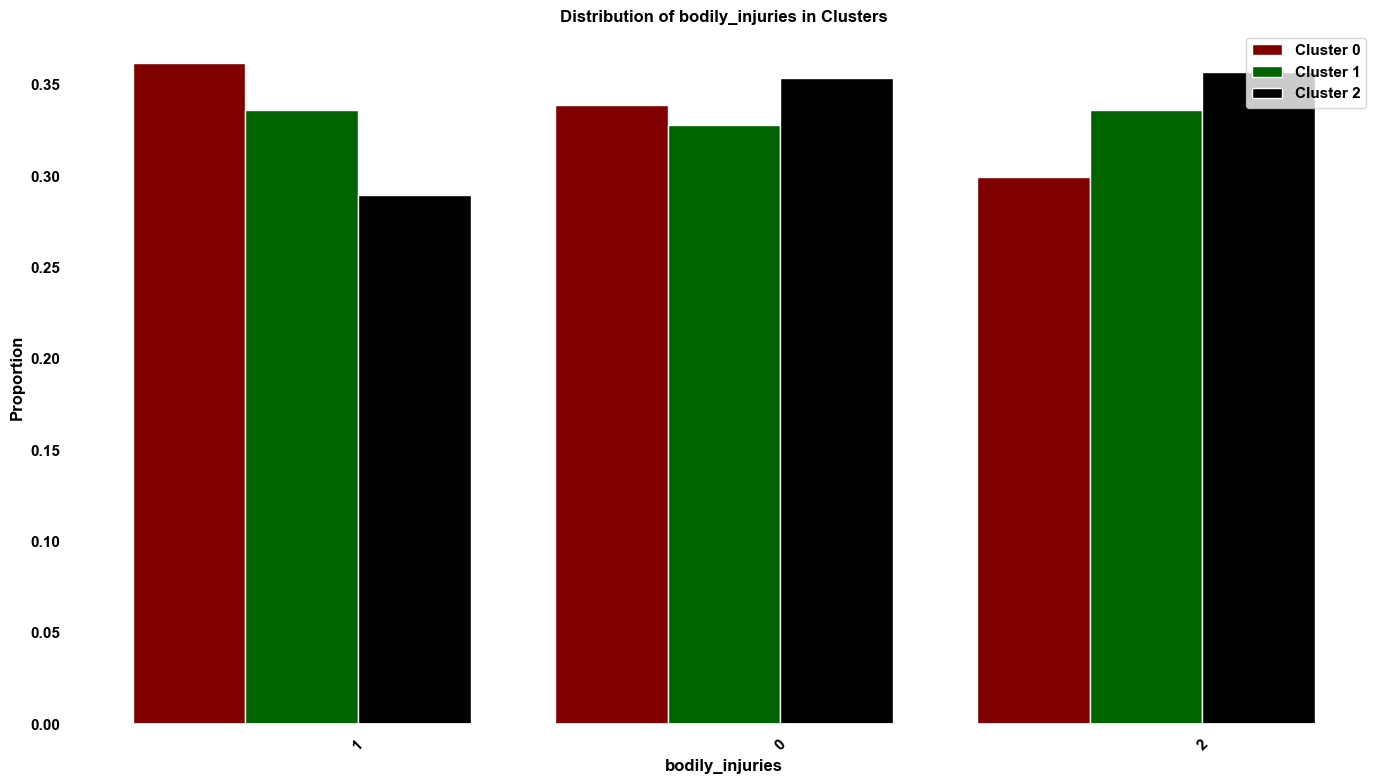

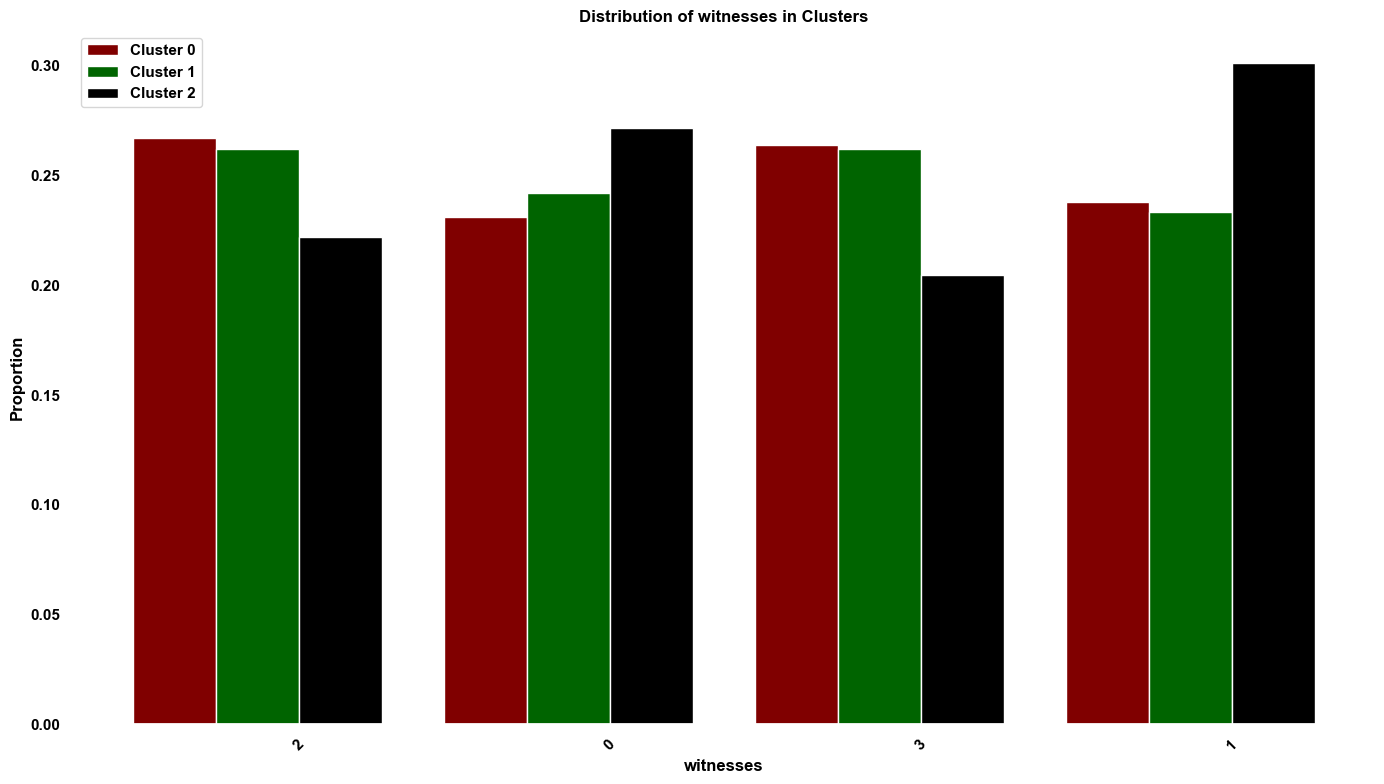

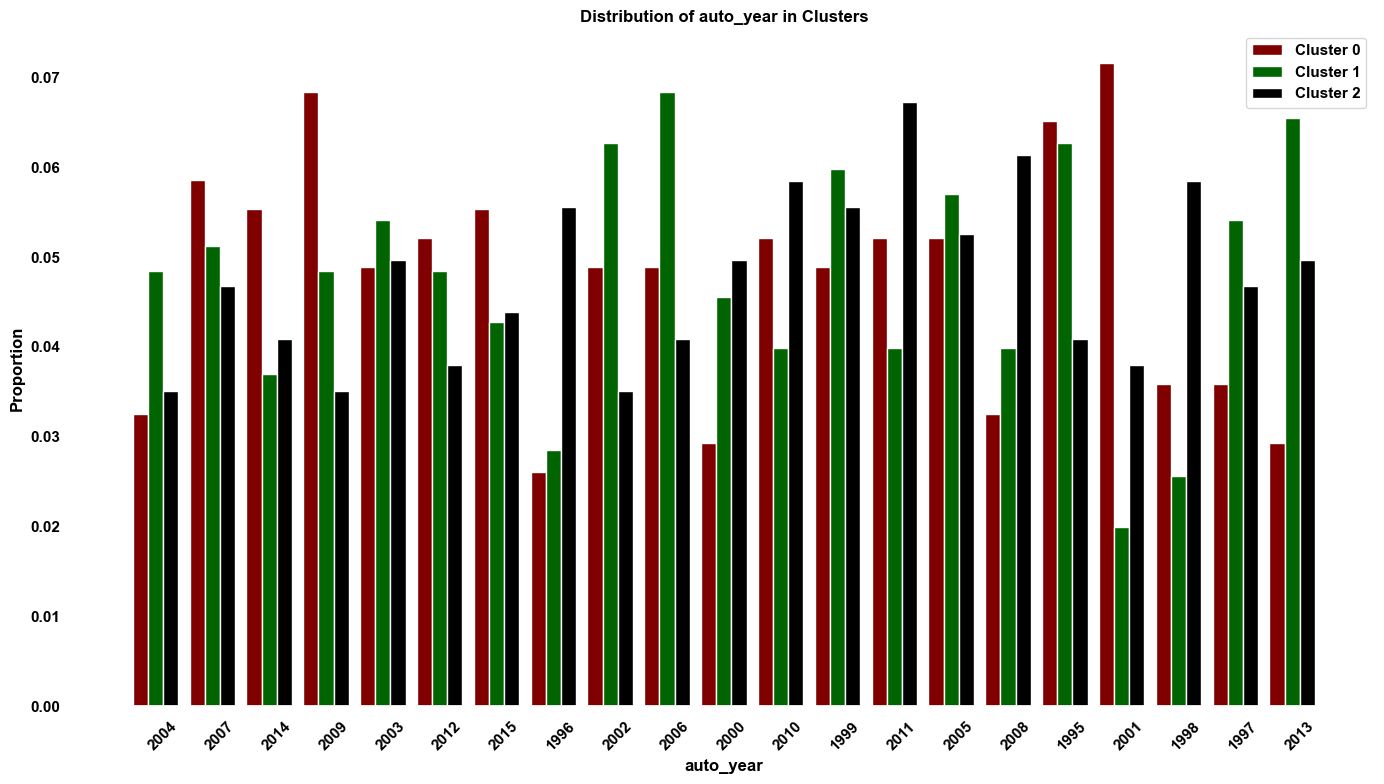

In [131]:
# Additional analysis: distribution of categorical variables
cluster_colors = ['maroon', 'darkgreen', 'black']
cluster_labels = ['Cluster 0', 'Cluster 1', 'Cluster 2']

for feature in categorical_features:
    plt.figure(figsize=(14, 8))
    
    # Get unique categories
    categories = df[feature].unique()
    n_categories = len(categories)
    
    # Set bar width and positions
    total_bar_width = 0.8  # Total width allocated for each category
    bar_width = total_bar_width / 3  # Allocate width equally to 3 clusters
    
    index = np.arange(n_categories)  # Positions for the categories
    
    for cluster, color in zip(range(3), cluster_colors):
        cluster_df = df[df['Cluster'] == cluster]
        category_counts = cluster_df[feature].value_counts(normalize=True).reindex(categories, fill_value=0)
        
        # Shift bars closer together
        plt.bar(index + cluster * bar_width - total_bar_width / 2, category_counts, bar_width, color=color, label=f'{cluster_labels[cluster]}')
    
    # Adjust x-axis ticks and labels
    plt.xlabel(feature)
    plt.ylabel('Proportion')
    plt.title(f'Distribution of {feature} in Clusters')
    plt.xticks(index, categories, rotation=45)
    
    # Add legend and adjust layout
    plt.legend()
    plt.tight_layout()
    plt.show()

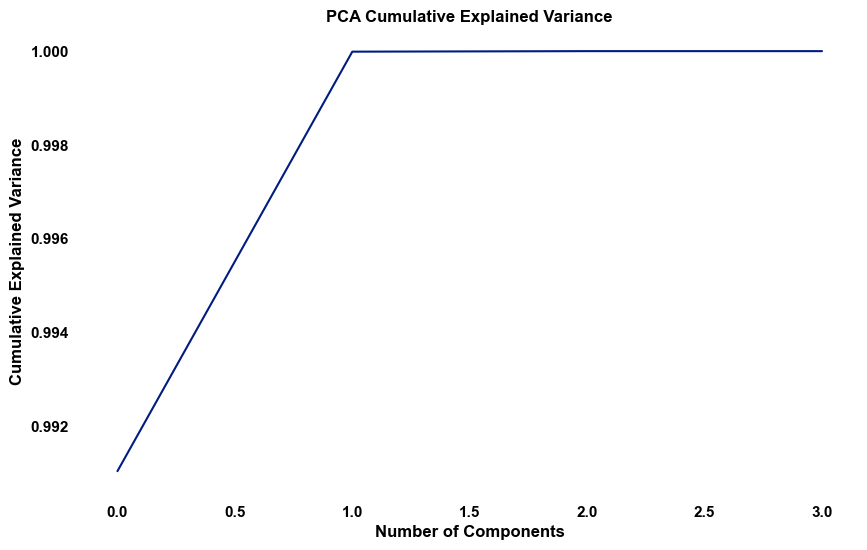

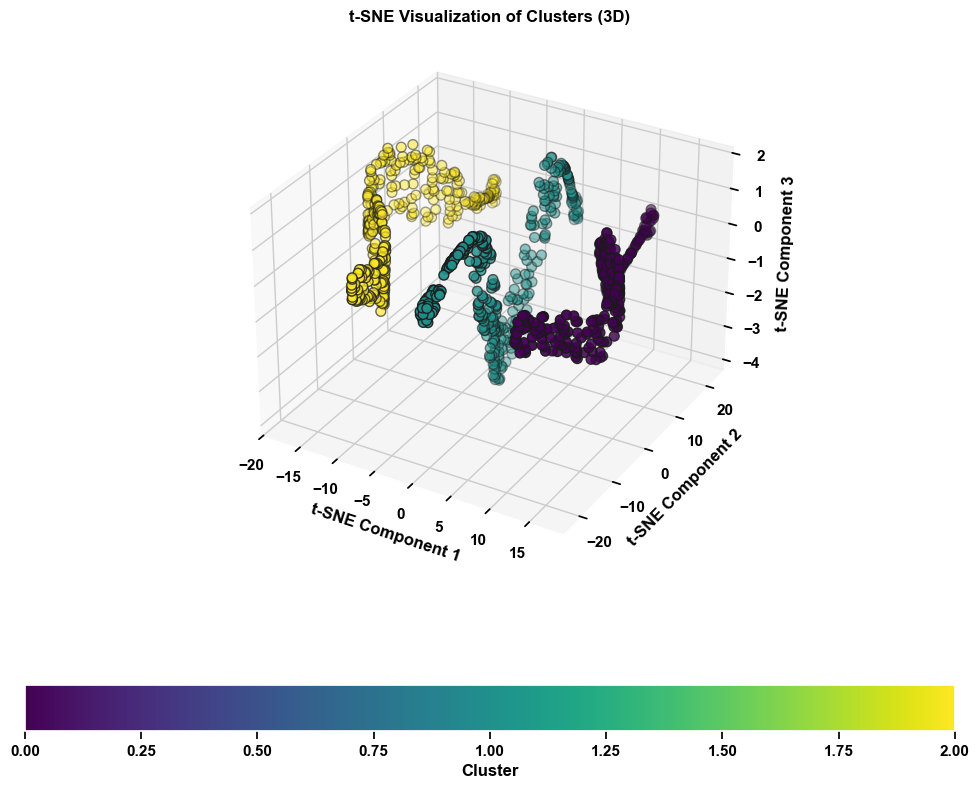


Cluster 0 mean values:
age_boxcox                          4.2048
policy_annual_premium_boxcox     1255.6167
total_claim_amount_boxcox      113063.6933
vehicle_claim_boxcox            89664.8311
dtype: float64

Cluster 1 mean values:
age_boxcox                          4.1627
policy_annual_premium_boxcox     1268.1099
total_claim_amount_boxcox      107774.8565
vehicle_claim_boxcox            87218.6477
dtype: float64

Cluster 2 mean values:
age_boxcox                          4.1880
policy_annual_premium_boxcox     1255.1129
total_claim_amount_boxcox      110474.3838
vehicle_claim_boxcox            89571.0245
dtype: float64

Most common incident_hour_of_the_day in Cluster 0: 10

Most common incident_hour_of_the_day in Cluster 1: 17

Most common incident_hour_of_the_day in Cluster 2: 4

Most common number_of_vehicles_involved in Cluster 0: 1

Most common number_of_vehicles_involved in Cluster 1: 1

Most common number_of_vehicles_involved in Cluster 2: 1

Most common bodily_injuries in 

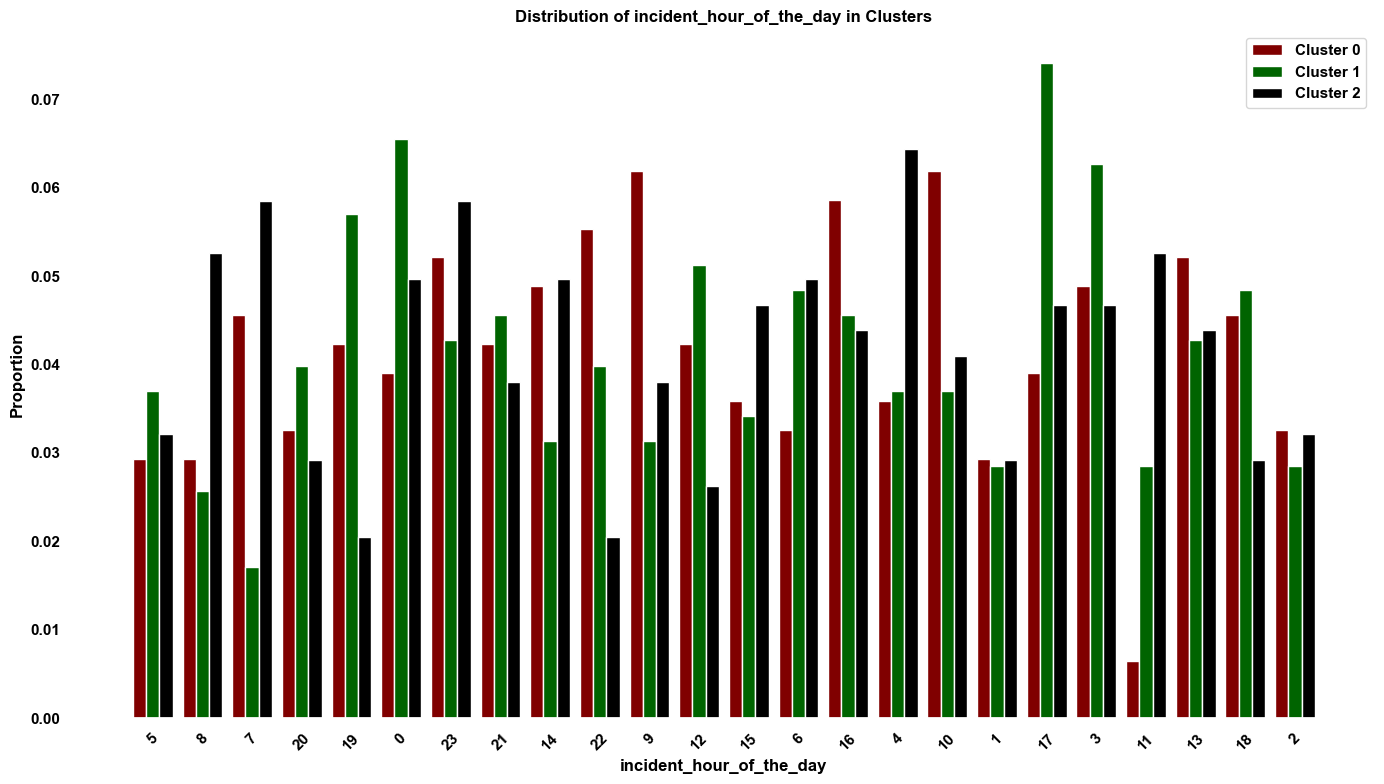

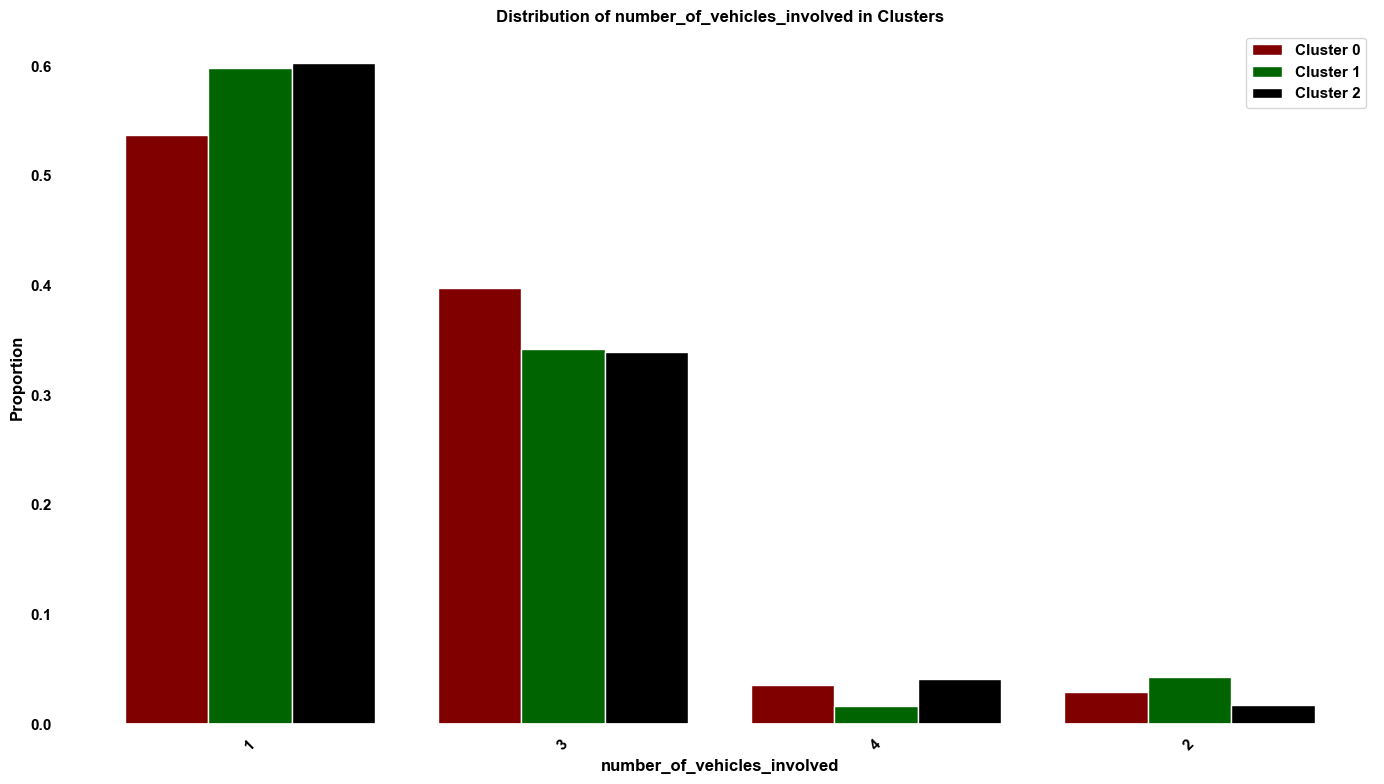

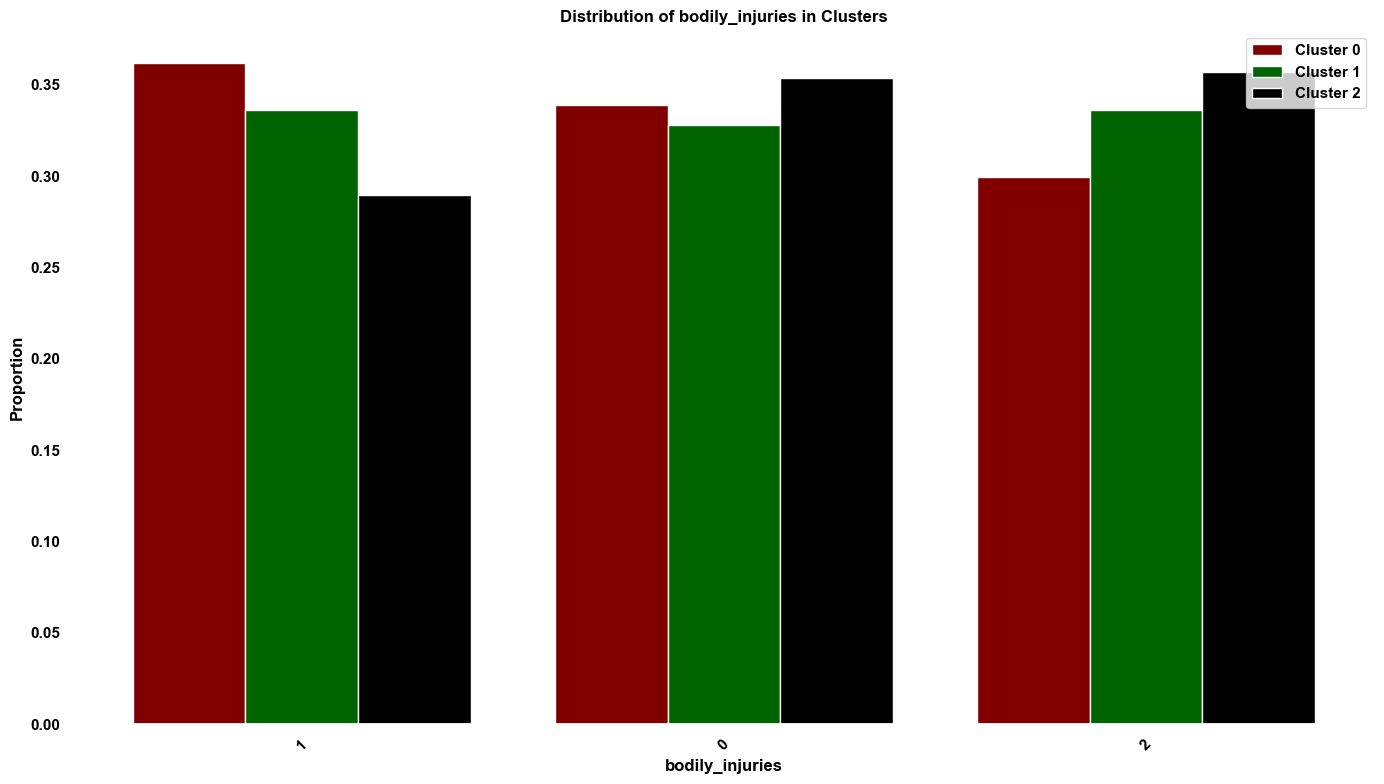

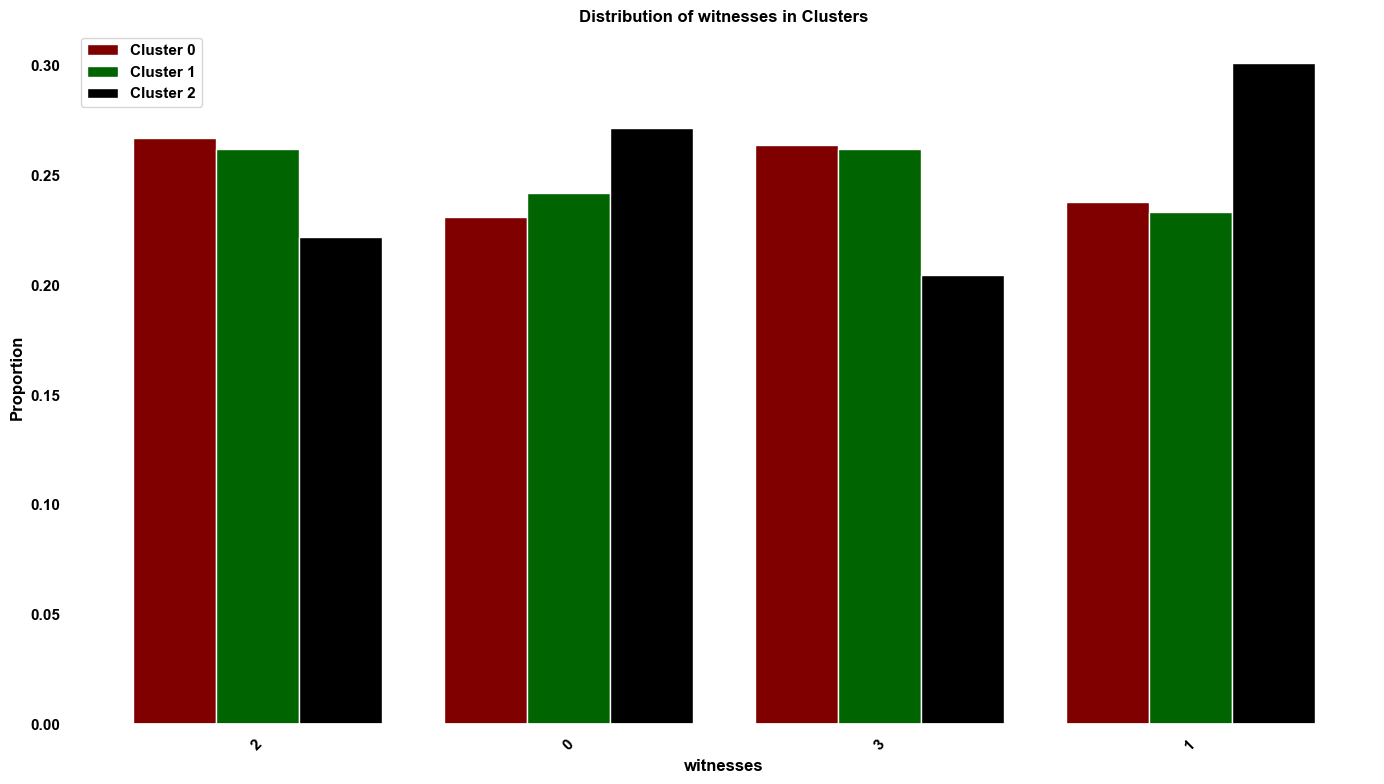

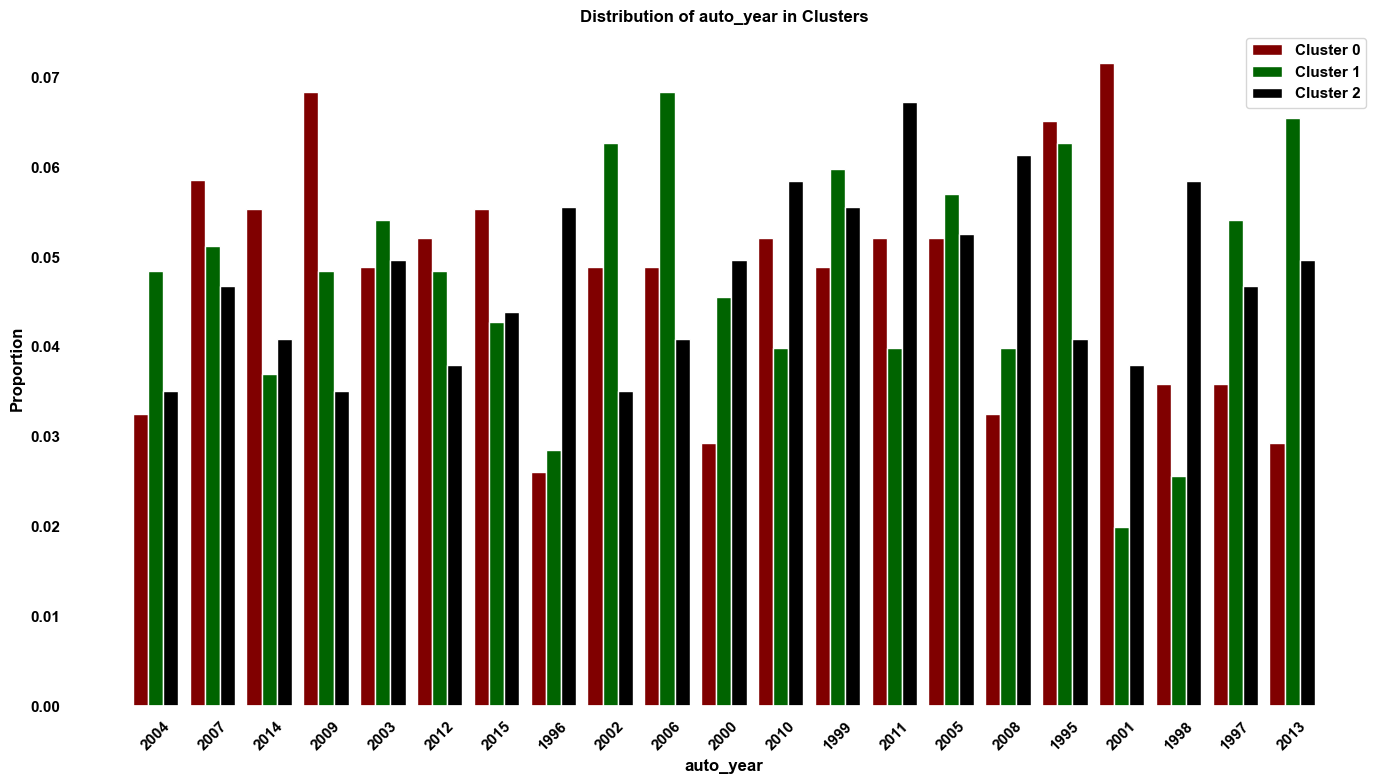

In [132]:
# Define colors for three clusters
cluster_colors = ['maroon', 'darkgreen', 'black']
cluster_labels = ['Cluster 0', 'Cluster 1', 'Cluster 2']

# PCA for feature importance
pca = PCA()
pca_result = pca.fit_transform(df[continuous_features])

# Plot cumulative explained variance ratio
plt.figure(figsize=(10, 6))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('PCA Cumulative Explained Variance')
plt.show()

# t-SNE for visualization
tsne = TSNE(n_components=3, random_state=42)
tsne_result = tsne.fit_transform(df1[fea1])

# Create a 3D scatter plot
fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')

scatter = ax.scatter(tsne_result[:, 0], tsne_result[:, 1], tsne_result[:, 2], c=df['Cluster'], cmap='viridis', s=50, edgecolor='k')
# Add color bar
cbar = plt.colorbar(scatter, ax=ax, orientation='horizontal')
cbar.set_label('Cluster')

# Set labels and title
ax.set_xlabel('t-SNE Component 1')
ax.set_ylabel('t-SNE Component 2')
ax.set_zlabel('t-SNE Component 3')
ax.set_title('t-SNE Visualization of Clusters (3D)')

plt.show()

# Analyze cluster characteristics
for cluster in range(3):
    cluster_df = df[df['Cluster'] == cluster]
    print(f"\nCluster {cluster} mean values:")
    print(cluster_df[continuous_features].mean())

# For categorical features, look at the most common values in each cluster
for feature in categorical_features:
    for cluster in range(3):
        cluster_df = df[df['Cluster'] == cluster]
        print(f"\nMost common {feature} in Cluster {cluster}:", cluster_df[feature].value_counts().index[0])

# Additional analysis: distribution of categorical variables
for feature in categorical_features:
    plt.figure(figsize=(14, 8))
    
    # Get unique categories
    categories = df[feature].unique()
    n_categories = len(categories)
    
    # Set total width allocated for each category and calculate the bar width for the clusters
    total_bar_width = 0.8  # Reduce the width slightly to allow some spacing
    bar_width = total_bar_width / 3  # Divide total width by the number of clusters (3 in this case)
    
    # Define positions for the categories
    index = np.arange(n_categories)
    
    for cluster, color in zip(range(3), cluster_colors):
        cluster_df = df[df['Cluster'] == cluster]
        
        # Calculate the normalized counts for each category and reindex to ensure alignment
        category_counts = cluster_df[feature].value_counts(normalize=True).reindex(categories, fill_value=0)
        
        # Plot bars for each cluster, ensuring they are centered around the category index
        plt.bar(index + (cluster - 1) * bar_width, category_counts, bar_width, color=color, label=f'{cluster_labels[cluster]}')

    # Set plot labels and title
    plt.xlabel(feature)
    plt.ylabel('Proportion')
    plt.title(f'Distribution of {feature} in Clusters')

    # Adjust the x-ticks to ensure they're aligned with the categories
    plt.xticks(index, categories, rotation=45)
    
    # Add legend and optimize layout
    plt.legend()
    plt.tight_layout()
    plt.show()

In [133]:
df.columns

Index(['months_as_customer', 'policy_bind_date', 'policy_state',
       'policy_deductable', 'insured_sex', 'insured_education_level',
       'insured_occupation', 'insured_hobbies', 'insured_relationship',
       'incident_date', 'incident_type', 'collision_type', 'incident_severity',
       'authorities_contacted', 'incident_state', 'incident_city',
       'incident_hour_of_the_day', 'number_of_vehicles_involved',
       'property_damage', 'bodily_injuries', 'witnesses',
       'police_report_available', 'auto_make', 'auto_year', 'fraud_reported',
       'age_boxcox', 'policy_annual_premium_boxcox',
       'total_claim_amount_boxcox', 'injury_claim_cube', 'property_claim_cube',
       'vehicle_claim_boxcox', 'insurance_age', 'vehicle_age', 'Cluster'],
      dtype='object')

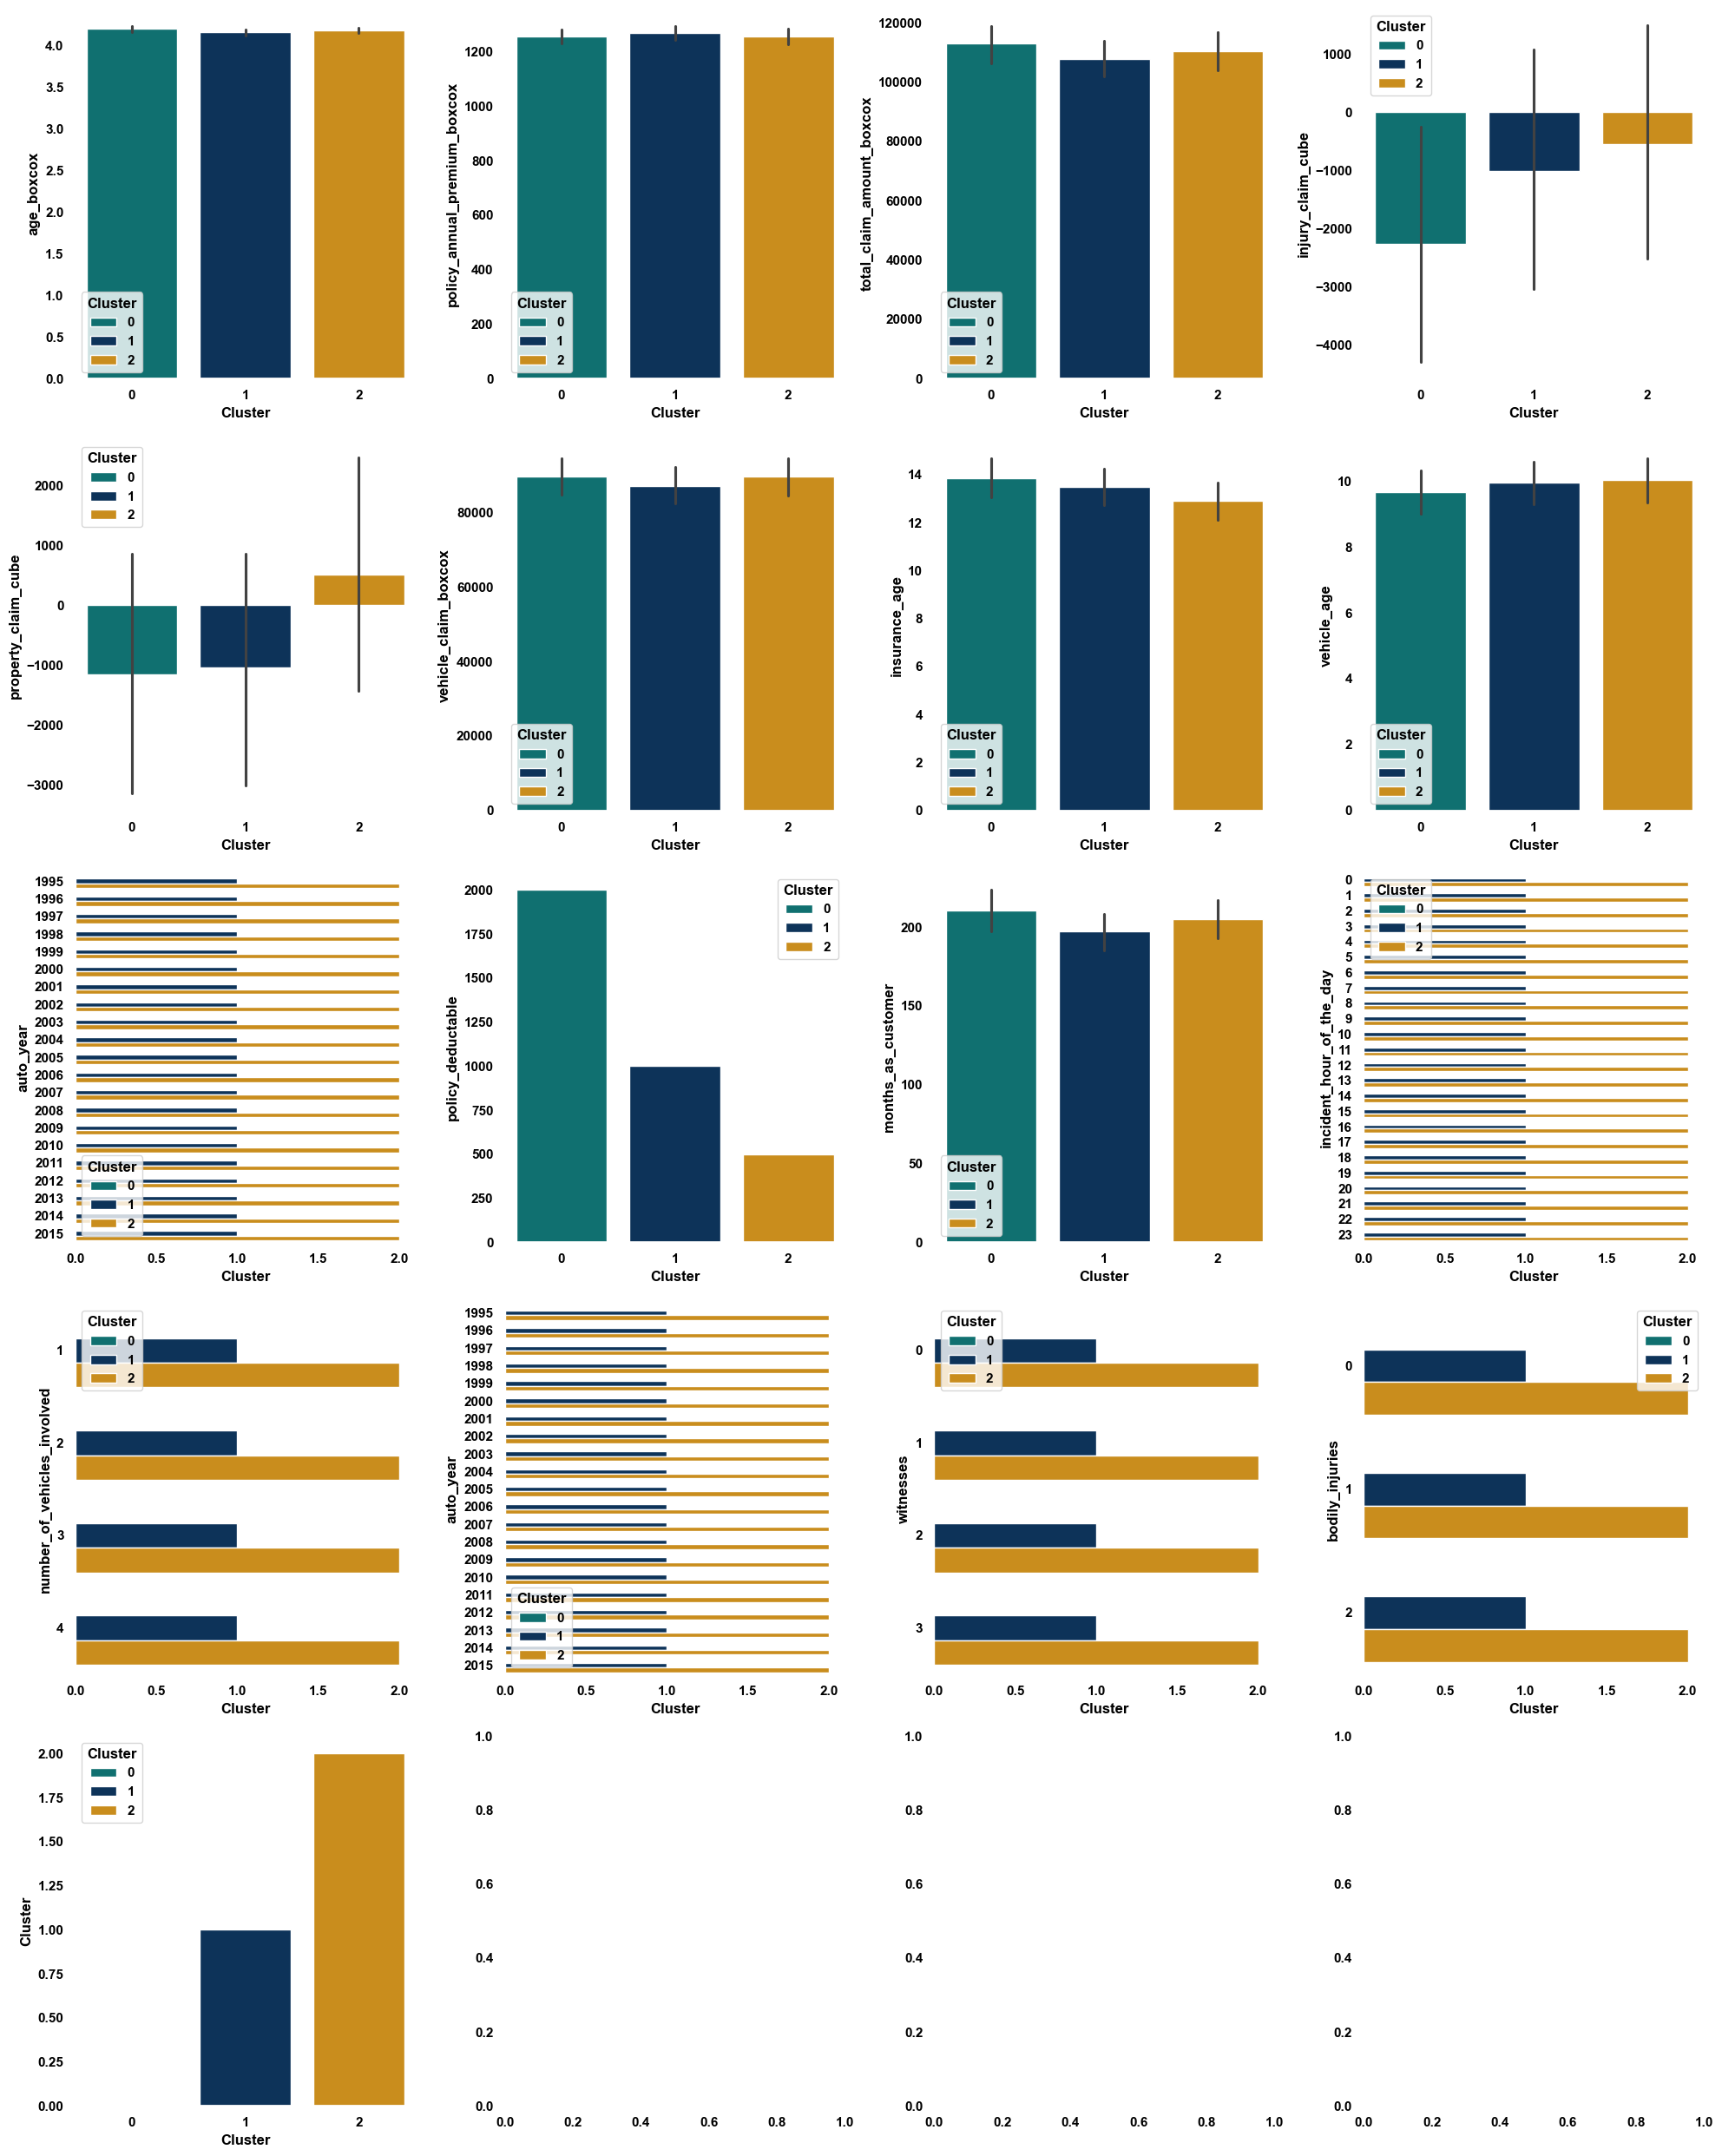

In [134]:
numeric_columns = continuous+discrete+['Cluster']

# Calculate number of rows needed
num_plots = len(numeric_columns)
num_rows = int(np.ceil(num_plots / 4))

# Create subplots with appropriate figsize
fig, axes = plt.subplots(ncols=4, nrows=num_rows, figsize=(20, num_rows * 5))
axes = axes.flatten()

for i,col in enumerate(numeric_columns):
    sns.barplot(data=df, x='Cluster', y=col, hue='Cluster',hue_order=[0,1,2],palette=['#008080','#003366','#e69500'],ax=axes[i])
plt.tight_layout()
plt.show()


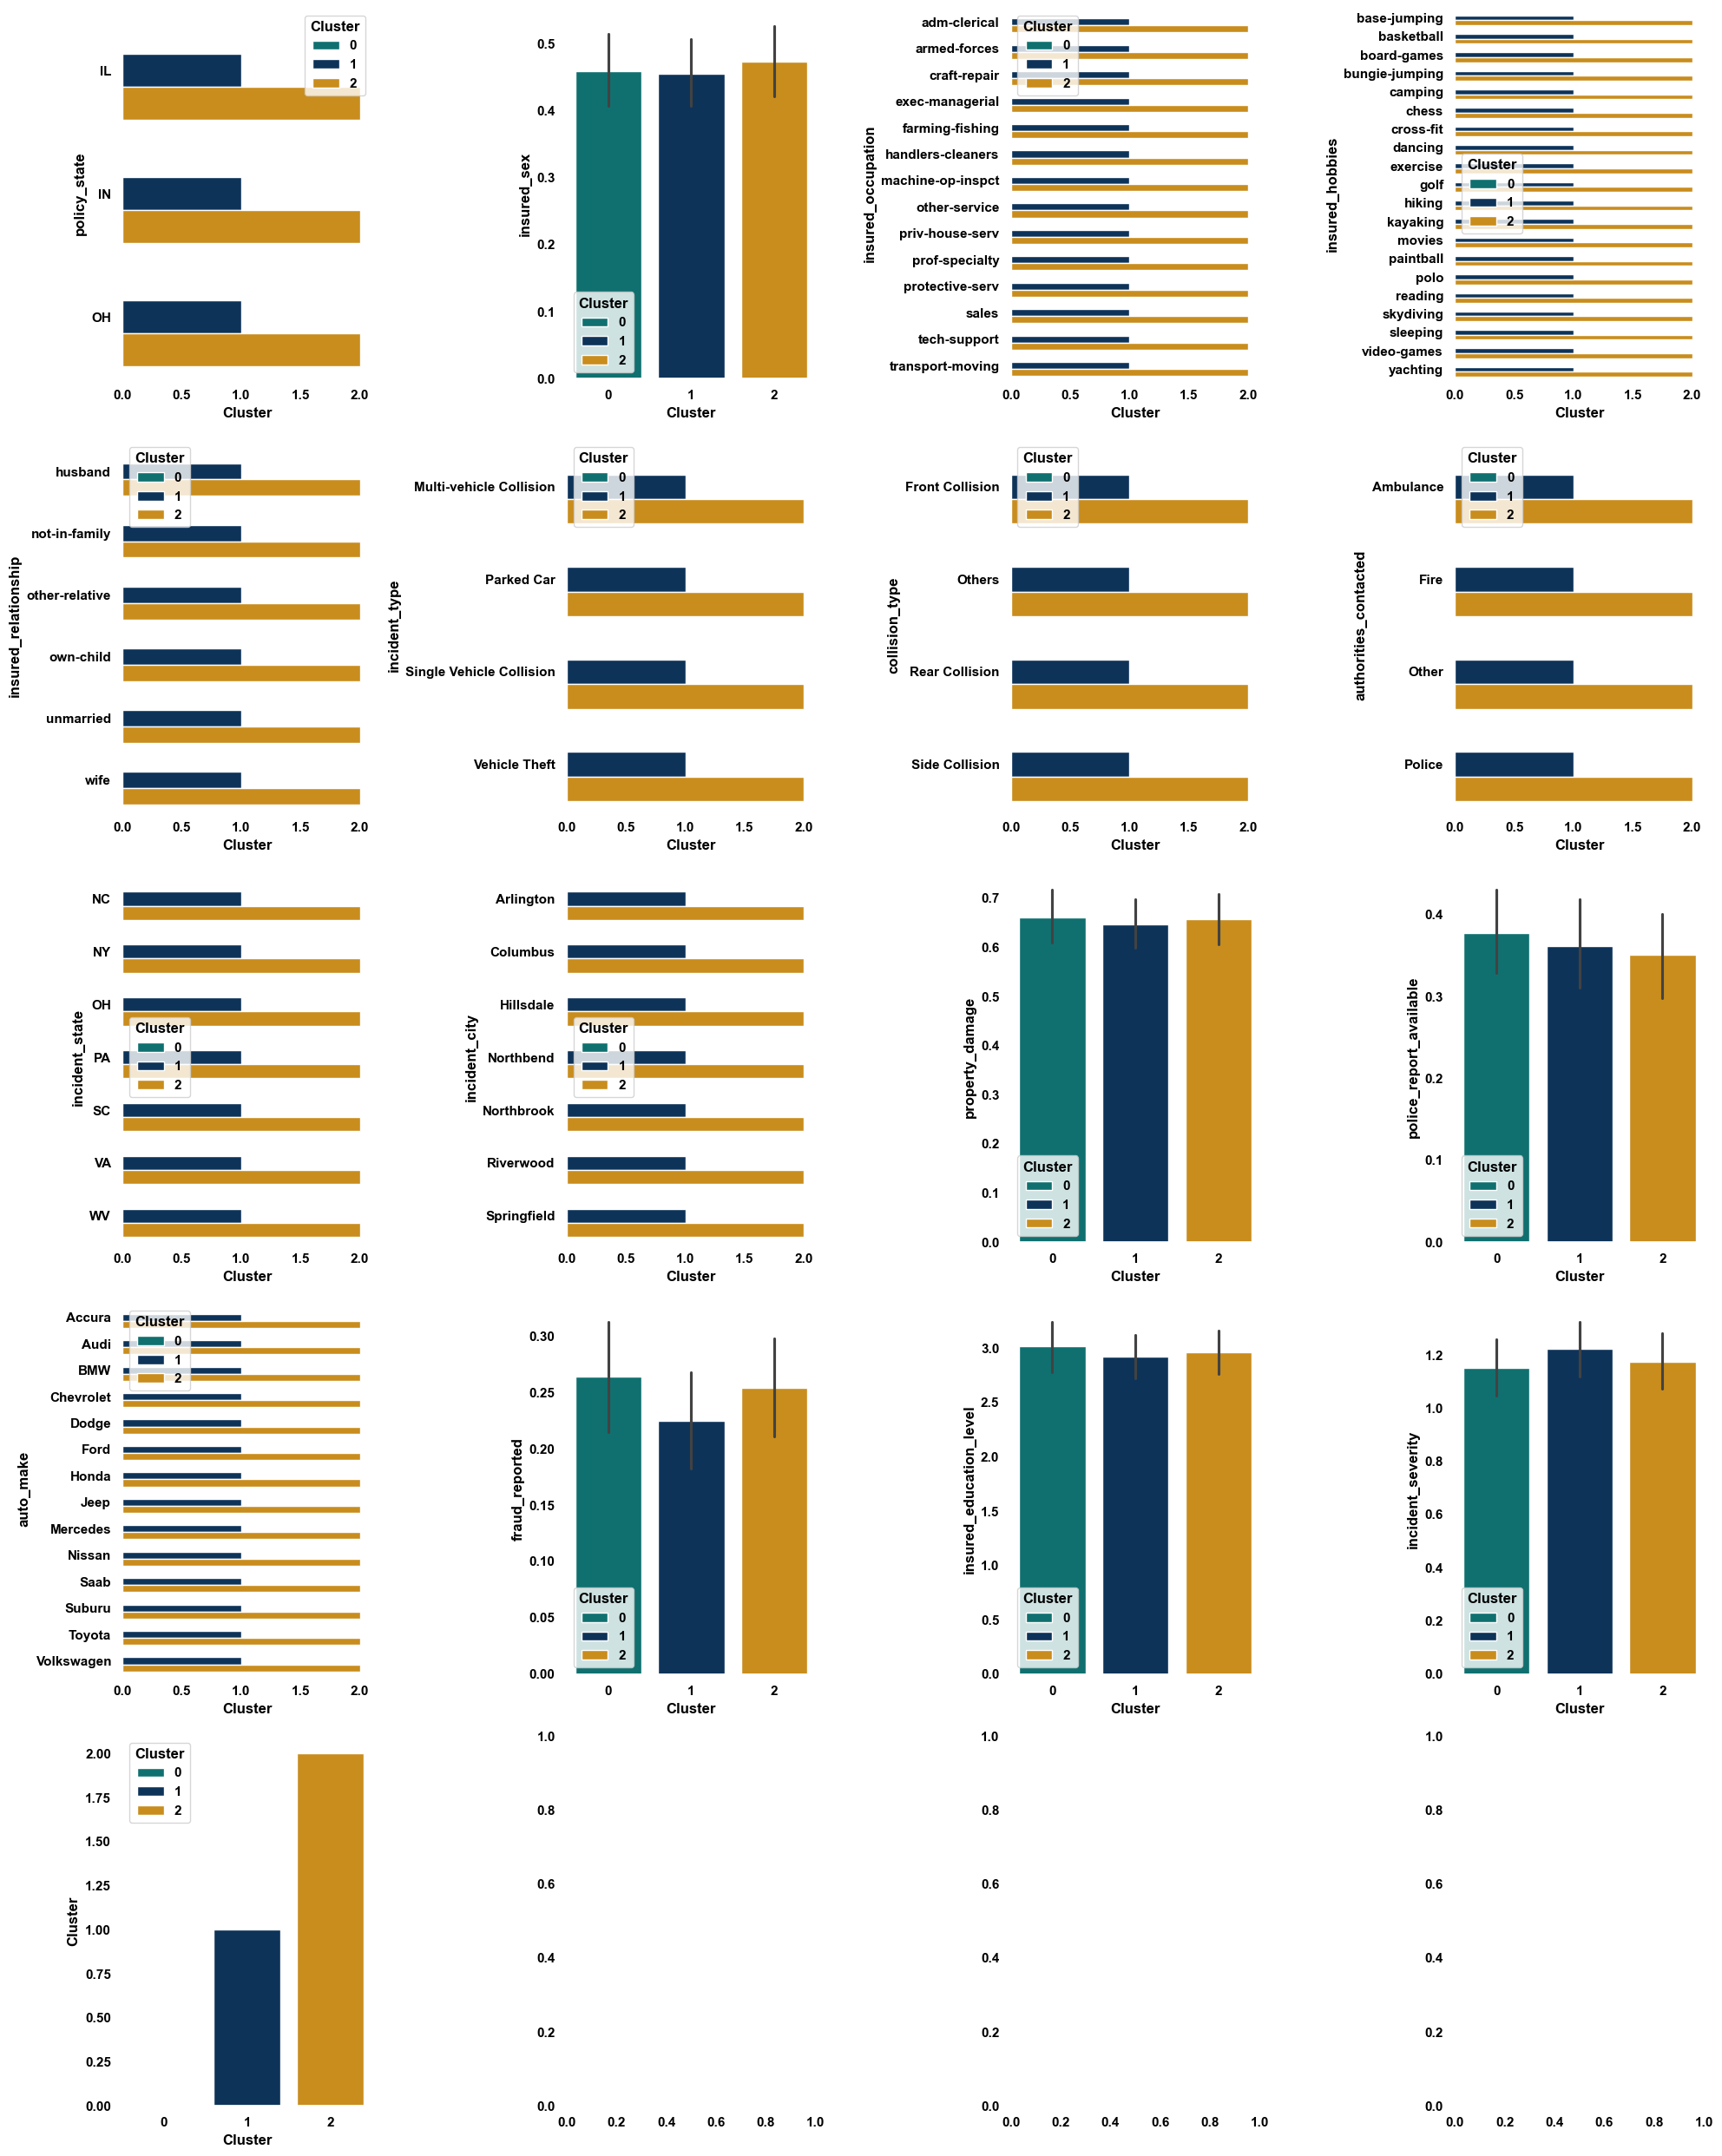

In [135]:
cat_cols = nominal+ordinal+['Cluster']

# Calculate number of rows needed
num_plots = len(cat_cols)
num_rows = int(np.ceil(num_plots / 4))

# Create subplots with appropriate figsize
fig, axes = plt.subplots(ncols=4, nrows=num_rows, figsize=(20, num_rows * 5))
axes = axes.flatten()

for i,col in enumerate(cat_cols):
    sns.barplot(data=df, x='Cluster', y=col, hue='Cluster',hue_order=[0,1,2],palette=['#008080','#003366','#e69500'],ax=axes[i])
plt.tight_layout()
plt.show()


## <span style="color:Aqua;">Categorical Encoded detail:</span>


Credit_Mix_map = { 'Poor': 0,'Bad':0, 'Standard':1, 'Good': 2  }
Payment_of_Min_Amount_map = { 'No':0, 'Nm':1, 'Yes':2 }
Payment_Behaviour_map = { 'Low_Spent_Small_Value_Payments': 0 , 'Low_Spent_Medium_Value_Payments':1, 'Low_Spent_Large_Value_Payments':2,
                         'High_Spent_Small_Value_Payments':3, 'High_Spent_Medium_Value_Payments':4, 'High_Spent_Large_Value_Payments':5
                        }
age_group_map = {'<18': 0, '18-25': 1, '26-35': 2, '36-50': 3, '50+': 4,}

## <span style="color:Khaki;">Clusters Overview:</span>

![Clustering](Cluster_Overview.png)  ![sss](Data_Driven_Insights.png)

## <span style="color:Khaki;">Key Insights:</span>
<span style="color: Chartreuse;font-size:120%;">&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Risk Segmentation: </span>The clustering has effectively separated customers into lower-risk (Cluster 0) and higher-risk (Cluster 1) groups.

<span style="color: Chartreuse;font-size:120%;">&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Credit Utilization: </span>Cluster 1 customers have more credit products but poorer credit scores, suggesting overextension of credit.

<span style="color: Chartreuse;font-size:120%;">&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Payment Behavior: </span> Cluster 0 customers are more punctual with payments and have fewer delays.

<span style="color: Chartreuse;font-size:120%;">&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Income vs. Debt: </span> Despite lower incomes, Cluster 1 customers have higher outstanding debt, indicating potential financial stress.

<span style="color: Chartreuse;font-size:120%;">&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Financial Management: </span> Cluster 0 customers show better financial management with higher savings rates and lower debt-to-income ratios.

<span style="color: Chartreuse;font-size:120%;">&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Credit Inquiries: </span> The higher number of credit inquiries in Cluster 1 might indicate these customers are seeking more credit, possibly due to financial difficulties.

<span style="color: white;font-size:105%;"> These insights can be used to tailor financial products, adjust risk assessments, and develop targeted financial education or assistance programs for each cluster. The clear separation between clusters suggests that this segmentation could be valuable for strategic decision-making in customer relationship management and risk mitigation. </span>

# <span style="color:Aqua;">Training DB Scan model:</span>


In [136]:
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score
import numpy as np

# Assuming df1[fea1] contains your data
X = df1[fea1].values

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

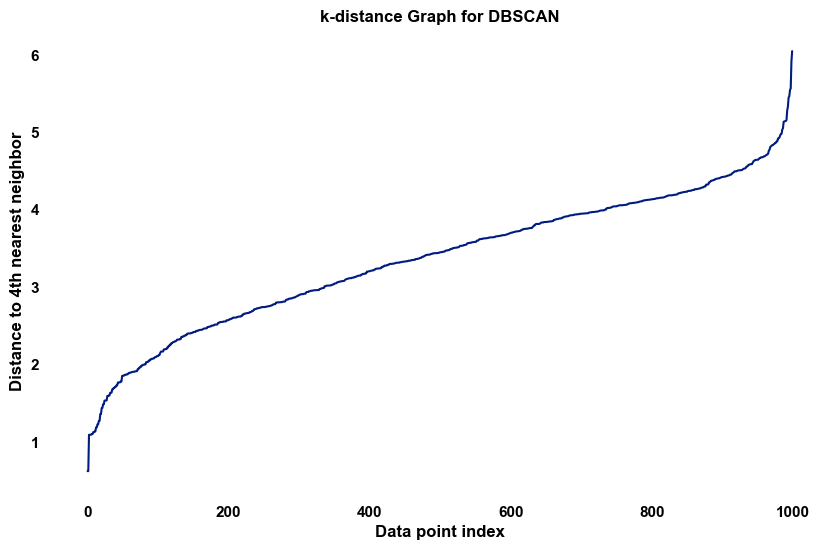

In [137]:
from sklearn.neighbors import NearestNeighbors
import numpy as np
import matplotlib.pyplot as plt

# Compute the distances to the k-nearest neighbors
neighbors = NearestNeighbors(n_neighbors=2)
neighbors_fit = neighbors.fit(X_scaled)
distances, indices = neighbors_fit.kneighbors(X_scaled)

# Sort the distances and plot them
distances = np.sort(distances[:, 1])
plt.figure(figsize=(10, 6))
plt.plot(distances)
plt.ylabel('Distance to 4th nearest neighbor')
plt.xlabel('Data point index')
plt.title('k-distance Graph for DBSCAN')
plt.show()

In [138]:
# Initialize DBSCAN with adjusted parameters based on the k-distance graph
for i in np.arange(4.5,15,0.5):
    dbscan = DBSCAN(eps=i, min_samples=5)  # Adjust eps based on the graph
    
    # Fit and predict clusters
    labels = dbscan.fit_predict(df1[fea1])
    
    # Check the number of clusters and noise points
    n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
    n_noise = list(labels).count(-1)
    mask = labels != -1

    print(i,i,i,i,i,i,i)
    
    if len(set(labels[mask])) > 1:  # Silhouette requires at least 2 clusters
        silhouette_avg = silhouette_score(df1[fea1][mask], labels[mask])
        ch_score = calinski_harabasz_score(df1[fea1][mask], labels[mask])
        db_score = davies_bouldin_score(df1[fea1][mask], labels[mask])
        print(f"Silhouette Score: {silhouette_avg}")
        print(f"calinski_harabasz_score: {ch_score}")
        print(f"davies_bouldin_score: {db_score}")
    else:
        print("Cannot calculate Score: only 1 cluster found.")
    
    print(f"Number of clusters: {n_clusters}")
    print(f"Number of noise points: {n_noise}")

4.5 4.5 4.5 4.5 4.5 4.5 4.5
Silhouette Score: 0.87521967003069
calinski_harabasz_score: 132811.97677605442
davies_bouldin_score: 0.1516252086084283
Number of clusters: 8
Number of noise points: 948
5.0 5.0 5.0 5.0 5.0 5.0 5.0
Silhouette Score: 0.6633187911056717
calinski_harabasz_score: 142136.7287638845
davies_bouldin_score: 0.4438652531237981
Number of clusters: 20
Number of noise points: 866
5.5 5.5 5.5 5.5 5.5 5.5 5.5
Silhouette Score: 0.5641736304385311
calinski_harabasz_score: 123729.83656740868
davies_bouldin_score: 0.5356543853477073
Number of clusters: 37
Number of noise points: 706
6.0 6.0 6.0 6.0 6.0 6.0 6.0
Silhouette Score: 0.47672733143379786
calinski_harabasz_score: 81740.83331107016
davies_bouldin_score: 0.6570222618070335
Number of clusters: 45
Number of noise points: 556
6.5 6.5 6.5 6.5 6.5 6.5 6.5
Silhouette Score: 0.38175594585659733
calinski_harabasz_score: 58558.99603440108
davies_bouldin_score: 0.6940749887452343
Number of clusters: 47
Number of noise points: 381

In [139]:
dbscan = DBSCAN(eps=8.5, min_samples=5)
labels = dbscan.fit_predict(df1[fea1])

# Add cluster labels to the DataFrame
df_db = df1.copy()
df_db['cluster'] = labels

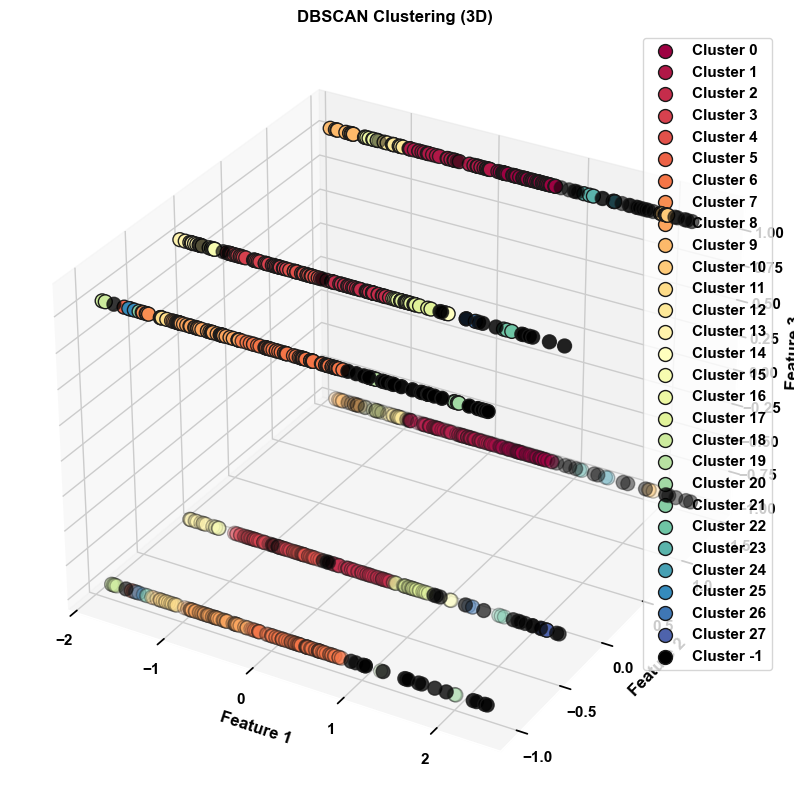

In [140]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import numpy as np

# Assuming `X_scaled` is your scaled data and `labels` is from DBSCAN.
unique_labels = set(labels)

# Plotting in 3D
fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')

# Generate colors for clusters (e.g., 8 clusters + noise)
colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))]

# Plot each cluster
for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black color for noise.
        col = [0, 0, 0, 1]
    
    # Mask to filter out points belonging to the current cluster k
    class_member_mask = (labels == k)
    
    # Select points for the current cluster (e.g., using first three features)
    xyz = X_scaled[class_member_mask]
    
    # Scatter plot for current cluster
    ax.scatter(xyz[:, 0], xyz[:, 1], xyz[:, 2], edgecolor='k', s=100, label=f"Cluster {k}", color=col)

# Set plot title and axis labels
ax.set_title('DBSCAN Clustering (3D)')
ax.set_xlabel('Feature 1')
ax.set_ylabel('Feature 2')
ax.set_zlabel('Feature 3')

# Show legend for the clusters
plt.legend()
plt.show()

KeyError: 'feature1'

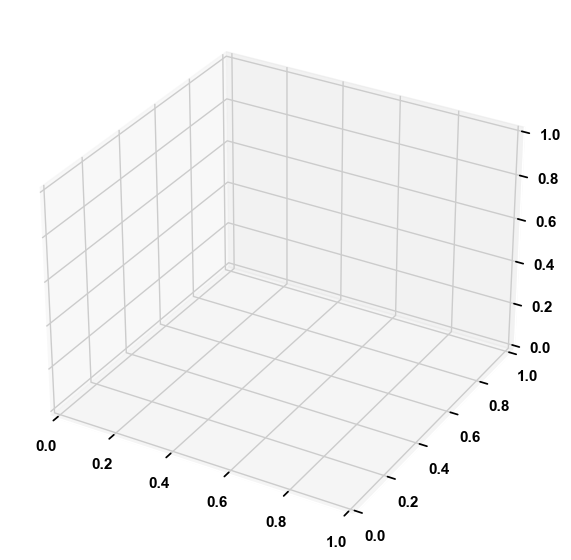

In [141]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Assuming the features you want to visualize are in columns 'feature1', 'feature2', and 'feature3'
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

# Plot clusters in 3D space
scatter = ax.scatter(df1['feature1'], df1['feature2'], df1['feature3'], c=df1['cluster'], cmap='viridis', s=50)

# Add a color bar to indicate cluster labels
legend1 = ax.legend(*scatter.legend_elements(), title="Clusters")
ax.add_artist(legend1)

# Set labels and title
ax.set_xlabel('Feature 1')
ax.set_ylabel('Feature 2')
ax.set_zlabel('Feature 3')
plt.title('3D Plot of DBSCAN Clusters')

plt.show()

In [124]:
a=[1,2,3,4]
one_hot_encoded_array = [0] * len(a)
x=1

In [125]:
selected_index = a.index(x)
one_hot_encoded_array[selected_index] = 1
one_hot_encoded_array

[1, 0, 0, 0]